#### Load Packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import math
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score
from xgboost import XGBRegressor
import optuna

# Ignore warnings ;)
import warnings
warnings.simplefilter("ignore")

import pickle

# set seed for reproductibility
np.random.seed(0)

#### Load Data

In [2]:
# 1. Data Loading
train = pd.read_csv('train_v9rqX0R.csv')
test = pd.read_csv('test_AbJTz2l.csv')

In [3]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


#### Data Structures

In [4]:
# 2. Initial Data Exploration - Train data
print("Train data shape:", train.shape)
print("\nTrain data info:")
print(train.info())
print("\nMissing values in train data:")
print(train.isnull().sum())

Train data shape: (8523, 12)

Train data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ K

In [5]:
train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Item_Identifier,8523,1559,FDW13,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Item_Weight,7060.0,NaN,NaN,NaN,12.857645,4.643456,4.555,8.77375,12.6,16.85,21.35
Item_Fat_Content,8523,5,Low Fat,5089,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Item_Visibility,8523.0,NaN,NaN,NaN,0.066132,0.051598,0.0,0.026989,0.053931,0.094585,0.328391
Item_Type,8523,16,Fruits and Vegetables,1232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Item_MRP,8523.0,NaN,NaN,NaN,140.992782,62.275067,31.29,93.8265,143.0128,185.6437,266.8884
Outlet_Identifier,8523,10,OUT027,935,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Outlet_Establishment_Year,8523.0,NaN,NaN,NaN,1997.831867,8.37176,1985.0,1987.0,1999.0,2004.0,2009.0
Outlet_Size,6113,3,Medium,2793,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Outlet_Location_Type,8523,3,Tier 3,3350,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# 3. Initial Data Exploration - Test data
print("Test data shape:", test.shape)
print("\nTest data info:")
print(test.info())
print("\nMissing values in test data:")
print(test.isnull().sum())

Test data shape: (5681, 11)

Test data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                4705 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB
None

Missing values in test data:
Item_Identifier      

#### Univariate Analysis

In [7]:
###Numeric Columns
numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales']

In [8]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,7060.0,12.857645,4.643456,4.555,8.773750,12.600000,16.850000,21.350000
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
Item_MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
Outlet_Establishment_Year,8523.0,1997.831867,8.371760,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


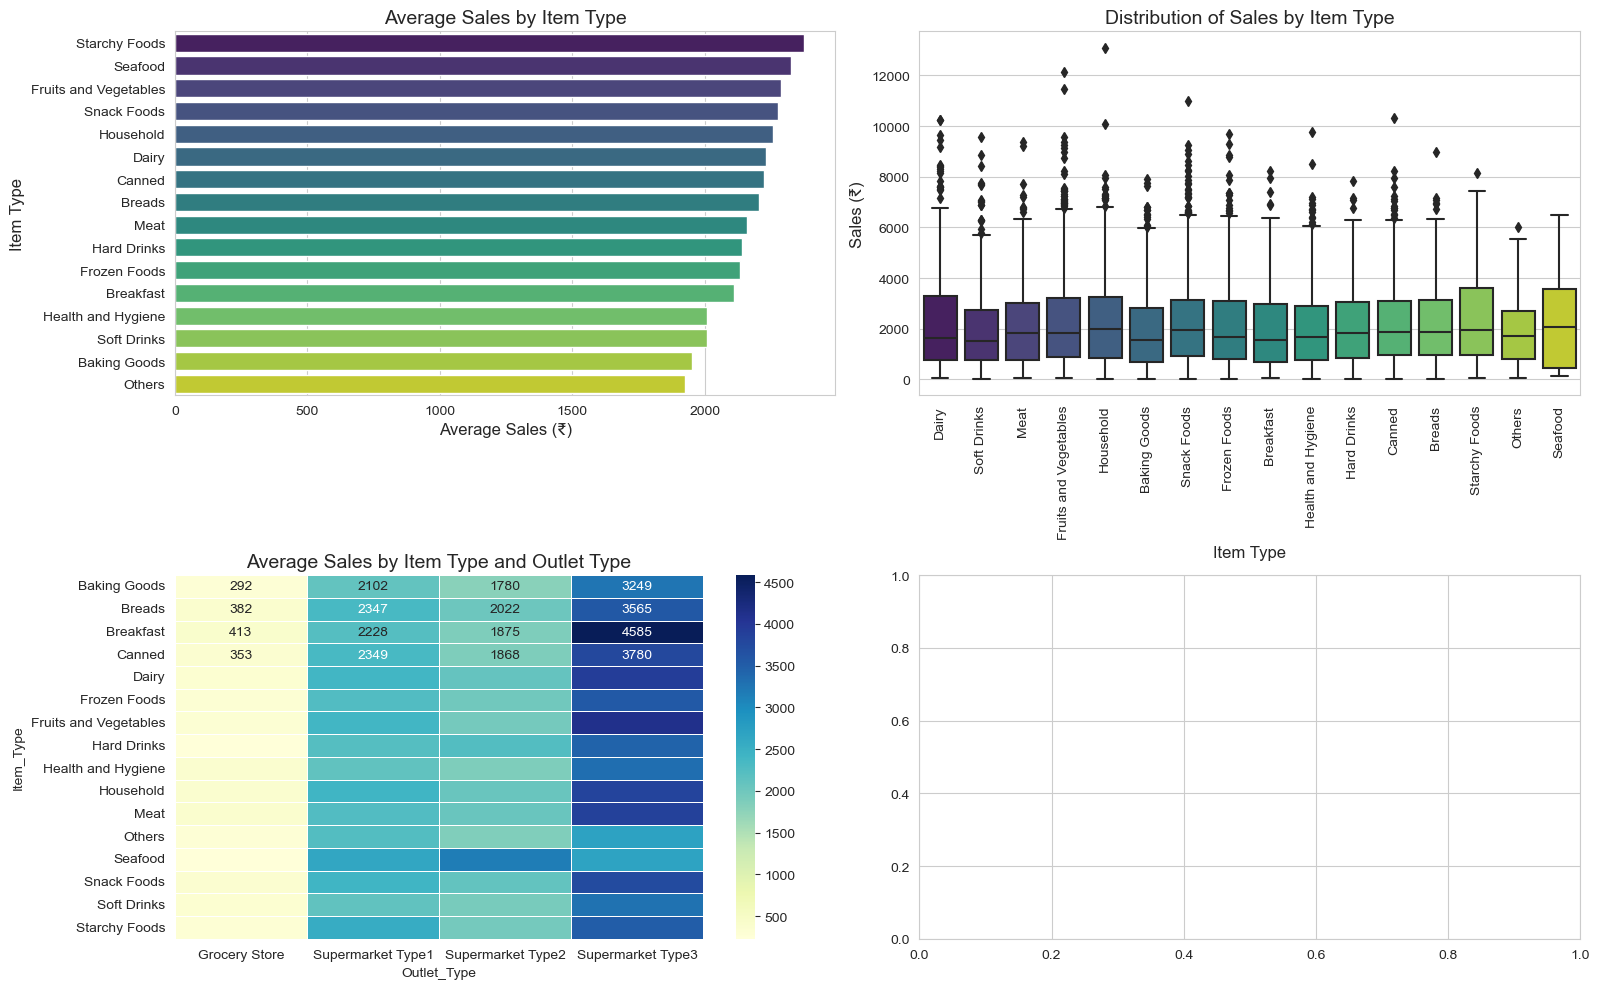

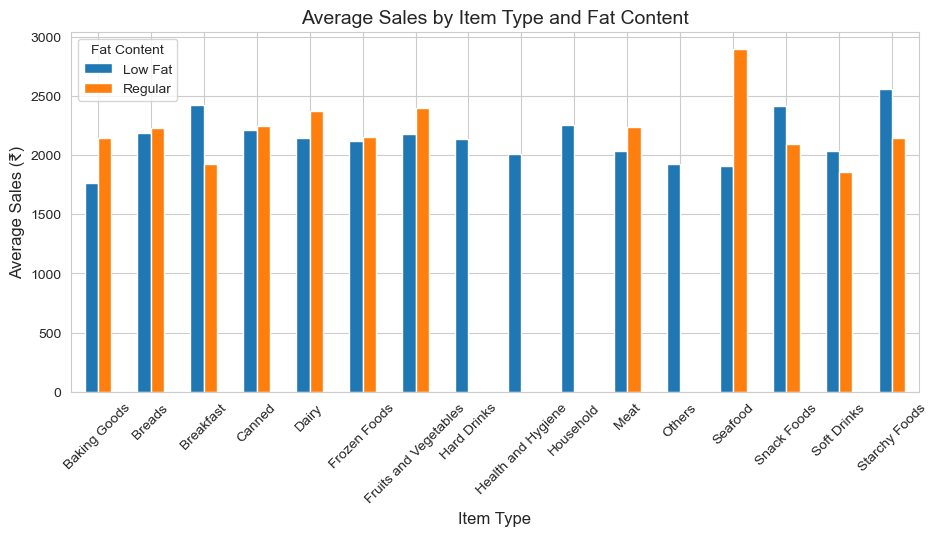

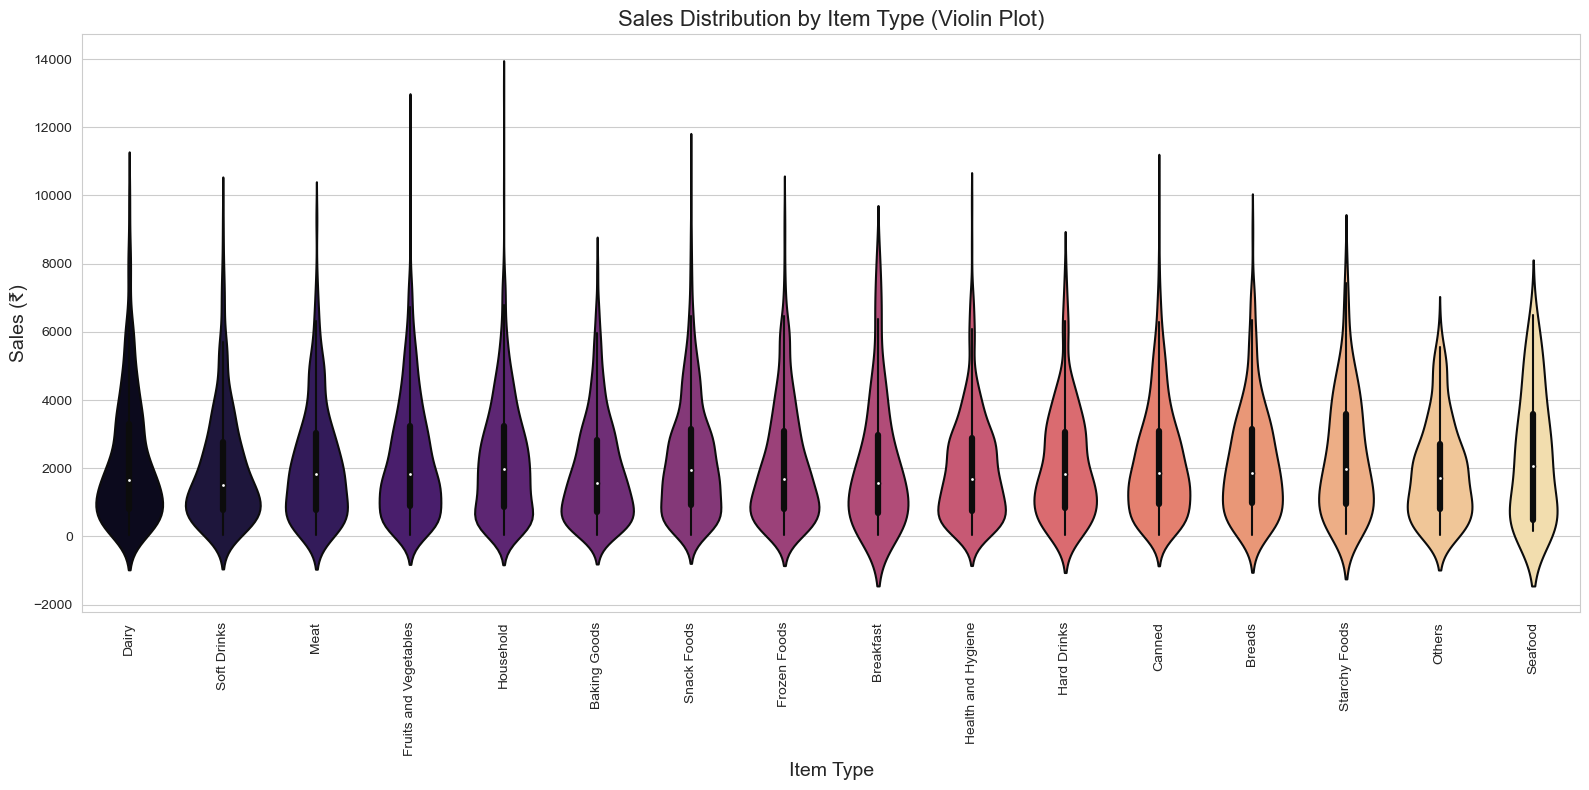

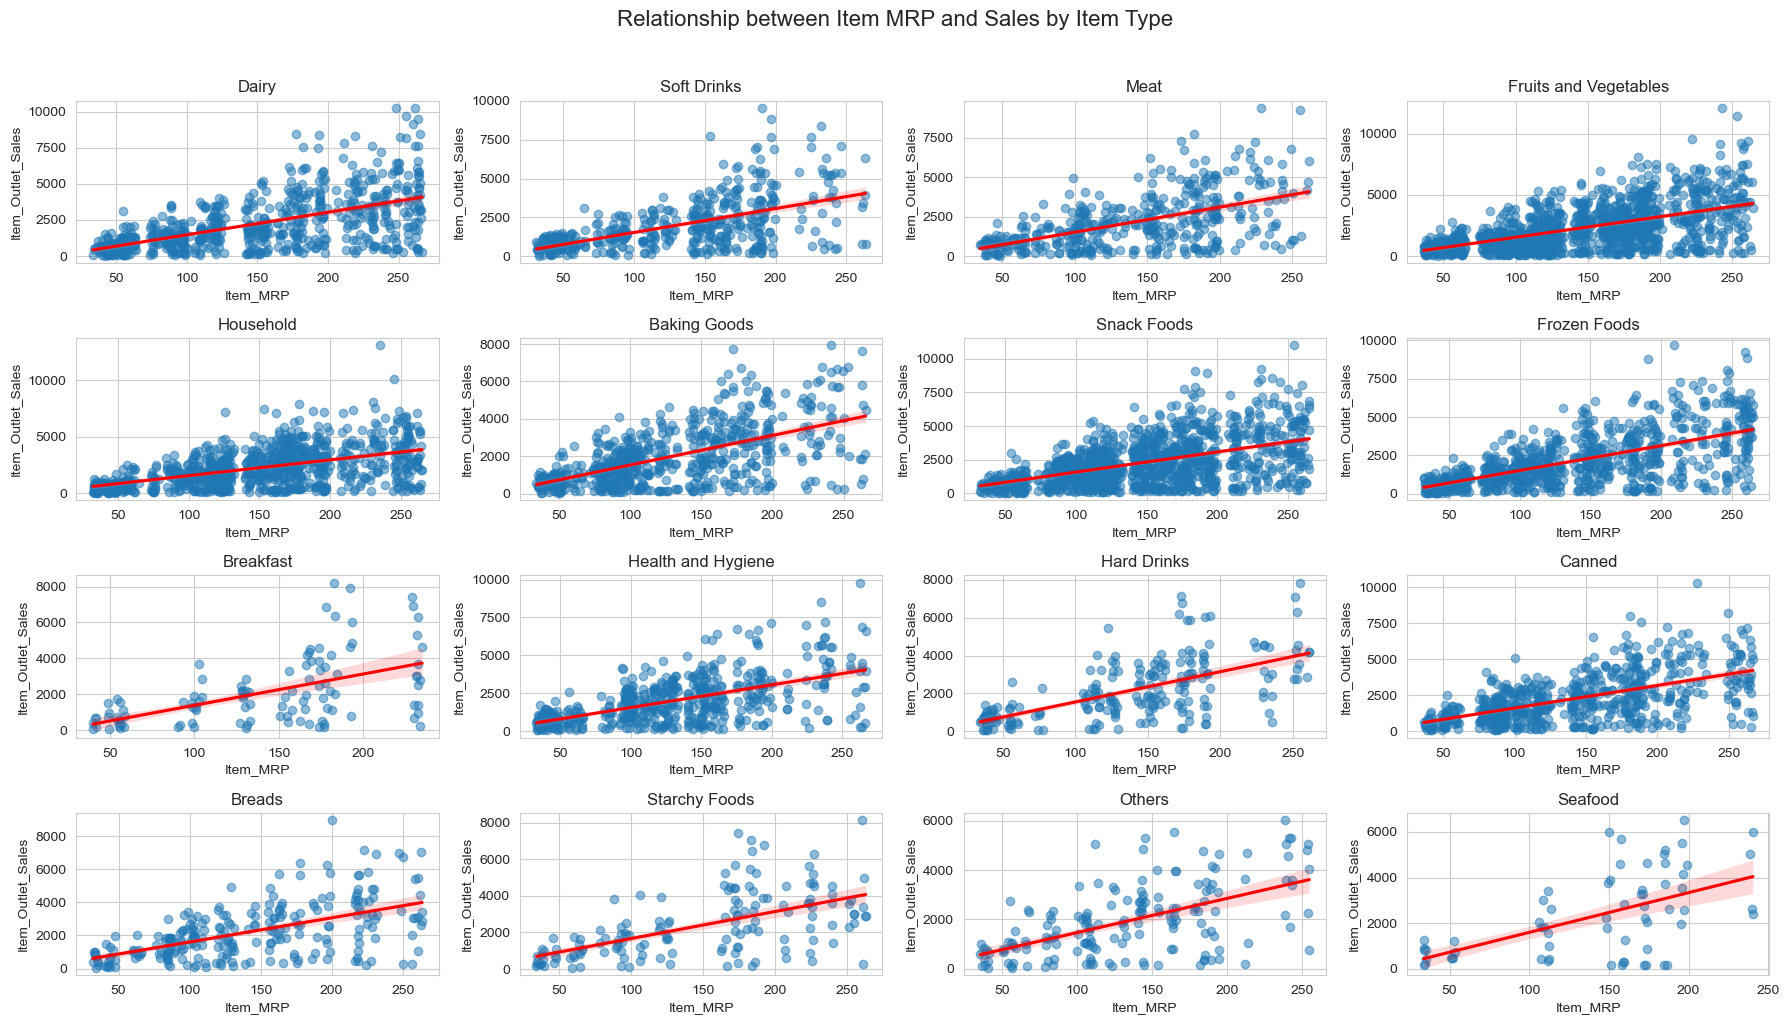

Top 3 Item Types by Average Sales:
Starchy Foods: ₹2374.33
Seafood: ₹2326.07
Fruits and Vegetables: ₹2289.01

Bottom 3 Item Types by Average Sales:
Soft Drinks: ₹2006.51
Baking Goods: ₹1952.97
Others: ₹1926.14

Variability in Sales by Item Type (Coefficient of Variation):
                          mean      std     cv
Item_Type                                     
Canned                 2225.19  1645.24  73.94
Others                 1926.14  1431.86  74.34
Breads                 2204.13  1644.24  74.60
Starchy Foods          2374.33  1773.95  74.71
Snack Foods            2277.32  1705.12  74.87
Household              2258.78  1692.25  74.92
Hard Drinks            2139.22  1606.19  75.08
Health and Hygiene     2010.00  1553.63  77.30
Meat                   2158.98  1695.23  78.52
Fruits and Vegetables  2289.01  1799.50  78.61
Baking Goods           1952.97  1546.79  79.20
Seafood                2326.07  1842.99  79.23
Frozen Foods           2132.87  1724.78  80.87
Soft Drinks           

In [9]:
######Visualise behavioural patterns of Sales
# Set up a larger figure size and style for better visualization
plt.figure(figsize=(16, 10))
sns.set_style("whitegrid")

# 1. Average sales by Item Type - Bar plot
plt.subplot(2, 2, 1)
avg_sales_by_type = train.groupby('Item_Type')['Item_Outlet_Sales'].mean().sort_values(ascending=False)
sns.barplot(x=avg_sales_by_type.values, y=avg_sales_by_type.index, palette='viridis')
plt.title('Average Sales by Item Type', fontsize=14)
plt.xlabel('Average Sales (₹)', fontsize=12)
plt.ylabel('Item Type', fontsize=12)
plt.tight_layout()

# 2. Distribution of Sales by Item Type - Box plot
plt.subplot(2, 2, 2)
sns.boxplot(x='Item_Type', y='Item_Outlet_Sales', data=train, palette='viridis')
plt.title('Distribution of Sales by Item Type', fontsize=14)
plt.xlabel('Item Type', fontsize=12)
plt.ylabel('Sales (₹)', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()

# 3. Sales by Item Type and Outlet Type - Heatmap
plt.subplot(2, 2, 3)
heatmap_data = train.pivot_table(values='Item_Outlet_Sales', 
                                index='Item_Type', 
                                columns='Outlet_Type', 
                                aggfunc='mean')
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5)
plt.title('Average Sales by Item Type and Outlet Type', fontsize=14)
plt.tight_layout()

# 4. Sales by Item Type and Fat Content - Grouped bar chart
plt.subplot(2, 2, 4)
# Standardize fat content values
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'})
fat_item_sales = train.groupby(['Item_Type', 'Item_Fat_Content'])['Item_Outlet_Sales'].mean().reset_index()
fat_item_pivot = fat_item_sales.pivot(index='Item_Type', columns='Item_Fat_Content', values='Item_Outlet_Sales')
fat_item_pivot.plot(kind='bar', figsize=(10, 6))
plt.title('Average Sales by Item Type and Fat Content', fontsize=14)
plt.xlabel('Item Type', fontsize=12)
plt.ylabel('Average Sales (₹)', fontsize=12)
plt.legend(title='Fat Content')
plt.xticks(rotation=45)
plt.tight_layout()

plt.tight_layout(pad=3.0)
plt.savefig('sales_by_item_type.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional detailed analysis
# 5. Create a separate violin plot for better distribution view
plt.figure(figsize=(16, 8))
sns.violinplot(x='Item_Type', y='Item_Outlet_Sales', data=train, palette='magma')
plt.title('Sales Distribution by Item Type (Violin Plot)', fontsize=16)
plt.xlabel('Item Type', fontsize=14)
plt.ylabel('Sales (₹)', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('sales_distribution_violin.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. Sales trend by item MRP within each item type
plt.figure(figsize=(18, 10))
for i, item_type in enumerate(train['Item_Type'].unique()):
    plt.subplot(4, 4, i+1)
    item_data = train[train['Item_Type'] == item_type]
    sns.regplot(x='Item_MRP', y='Item_Outlet_Sales', data=item_data, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title(item_type, fontsize=12)
    plt.tight_layout()
plt.suptitle('Relationship between Item MRP and Sales by Item Type', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('mrp_sales_by_type.png', dpi=300, bbox_inches='tight')
plt.show()

# 7. Extract top 3 and bottom 3 item types by average sales
top3_types = avg_sales_by_type.head(3)
bottom3_types = avg_sales_by_type.tail(3)

print("Top 3 Item Types by Average Sales:")
for item_type, avg_sales in top3_types.items():
    print(f"{item_type}: ₹{avg_sales:.2f}")

print("\nBottom 3 Item Types by Average Sales:")
for item_type, avg_sales in bottom3_types.items():
    print(f"{item_type}: ₹{avg_sales:.2f}")

# 8. Calculate variability in sales by item type (coefficient of variation)
cv_by_type = train.groupby('Item_Type')['Item_Outlet_Sales'].agg(
    ['mean', 'std']).assign(cv=lambda x: x['std']/x['mean']*100).sort_values('cv')

print("\nVariability in Sales by Item Type (Coefficient of Variation):")
print(cv_by_type[['mean', 'std', 'cv']].round(2))

In [10]:
# # Set up the figure - increasing number of rows to fit all plots
# plt.figure(figsize=(20, 20))
# plt.suptitle('Distribution of Numeric Variables in BigMart Dataset', fontsize=24, y=0.95)

# # Create both histograms and KDE plots for each numeric variable
# for i, col in enumerate(numeric_cols):
#     # Calculate statistics
#     mean_val = train[col].mean()
#     median_val = train[col].median()
#     skew_val = train[col].skew()
#     kurtosis_val = train[col].kurtosis()
    
#     # Check for missing values
#     missing = train[col].isnull().sum()
#     missing_pct = (missing / len(train)) * 100
    
#     # Histogram with KDE - now using 4 rows, 2 columns
#     plt.subplot(4, 2, 2*i+1)
#     sns.histplot(train[col].dropna(), kde=True, color='skyblue')
    
#     # Add vertical lines for mean and median
#     plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
#     plt.axvline(median_val, color='green', linestyle='-.', label=f'Median: {median_val:.2f}')
    
#     plt.title(f'Distribution of {col}', fontsize=16)
#     plt.xlabel(col, fontsize=14)
#     plt.ylabel('Frequency', fontsize=14)
#     plt.legend()
    
#     # Add statistics as text
#     stats_text = (f"Mean: {mean_val:.2f}\nMedian: {median_val:.2f}\n"
#                  f"Skewness: {skew_val:.2f}\nKurtosis: {kurtosis_val:.2f}\n"
#                  f"Missing: {missing} ({missing_pct:.2f}%)")
#     plt.annotate(stats_text, xy=(0.7, 0.8), xycoords='axes fraction', 
#                  bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))
    
#     # Box plot
#     plt.subplot(4, 2, 2*i+2)
#     sns.boxplot(x=train[col].dropna(), color='lightgreen')
#     plt.title(f'Boxplot of {col}', fontsize=16)
#     plt.xlabel(col, fontsize=14)
    
#     # If there are outliers, report their percentage
#     q1 = train[col].quantile(0.25)
#     q3 = train[col].quantile(0.75)
#     iqr = q3 - q1
#     lower_bound = q1 - 1.5 * iqr
#     upper_bound = q3 + 1.5 * iqr
#     outliers = train[(train[col] < lower_bound) | (train[col] > upper_bound)][col]
#     outlier_pct = (len(outliers) / len(train[col].dropna())) * 100
    
#     plt.annotate(f"Outliers: {len(outliers)} ({outlier_pct:.2f}%)", 
#                  xy=(0.7, 0.9), xycoords='axes fraction',
#                  bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))

# # Now we'll add the additional plots in the last row
# # Distribution of Item_Visibility with log transformation (handling skewness)
# plt.subplot(4, 2, 7)
# train['Item_Visibility_Log'] = np.log1p(train['Item_Visibility'])
# sns.histplot(train['Item_Visibility_Log'], kde=True, color='purple')
# plt.title('Distribution of Log-Transformed Item_Visibility', fontsize=16)
# plt.xlabel('Log(Item_Visibility + 1)', fontsize=14)
# plt.ylabel('Frequency', fontsize=14)

# # Check for zero values in visibility
# zero_visibility = (train['Item_Visibility'] == 0).sum()
# zero_visibility_pct = (zero_visibility / len(train)) * 100
# plt.annotate(f"Zero values: {zero_visibility} ({zero_visibility_pct:.2f}%)", 
#              xy=(0.7, 0.8), xycoords='axes fraction',
#              bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))

# # Scatter plot of MRP vs Sales
# plt.subplot(4, 2, 8)
# plt.scatter(train['Item_MRP'], train['Item_Outlet_Sales'], alpha=0.5, color='blue')
# plt.title('Item_MRP vs Item_Outlet_Sales', fontsize=16)
# plt.xlabel('Item_MRP', fontsize=14)
# plt.ylabel('Item_Outlet_Sales', fontsize=14)

# # Calculate correlation
# corr = train['Item_MRP'].corr(train['Item_Outlet_Sales'])
# plt.annotate(f"Correlation: {corr:.4f}", xy=(0.7, 0.9), xycoords='axes fraction',
#              bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))

# # Add regression line
# sns.regplot(x='Item_MRP', y='Item_Outlet_Sales', data=train, scatter=False, color='red')

# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig('numeric_variables_distribution.png', dpi=300, bbox_inches='tight')
# plt.show()

# # Create a correlation heatmap of numeric variables in a separate figure
# plt.figure(figsize=(10, 8))
# numeric_data = train[numeric_cols + ['Outlet_Establishment_Year']].copy()
# correlation_matrix = numeric_data.corr()

# # Create a mask for the upper triangle
# mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# # Draw the heatmap
# sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
#             square=True, linewidths=.5, annot=True, fmt='.2f', cbar_kws={"shrink": .8})

# plt.title('Correlation Matrix of Numeric Variables', fontsize=18)
# plt.tight_layout()
# plt.savefig('correlation_heatmap.png', dpi=300)
# plt.show()

# # Summary statistics for each numeric variable
# summary_stats = train[numeric_cols].describe().T

# # Add skewness and kurtosis to summary
# summary_stats['skew'] = train[numeric_cols].skew()
# summary_stats['kurtosis'] = train[numeric_cols].kurtosis()
# summary_stats['missing'] = train[numeric_cols].isnull().sum()
# summary_stats['missing_pct'] = (train[numeric_cols].isnull().sum() / len(train)) * 100

# print("Summary Statistics for Numeric Variables:")
# print(summary_stats.round(2))

# # Check for zero values in Item_Visibility
# zero_visibility_count = (train['Item_Visibility'] == 0).sum()
# print(f"\nNumber of items with zero visibility: {zero_visibility_count} ({zero_visibility_count/len(train)*100:.2f}%)")

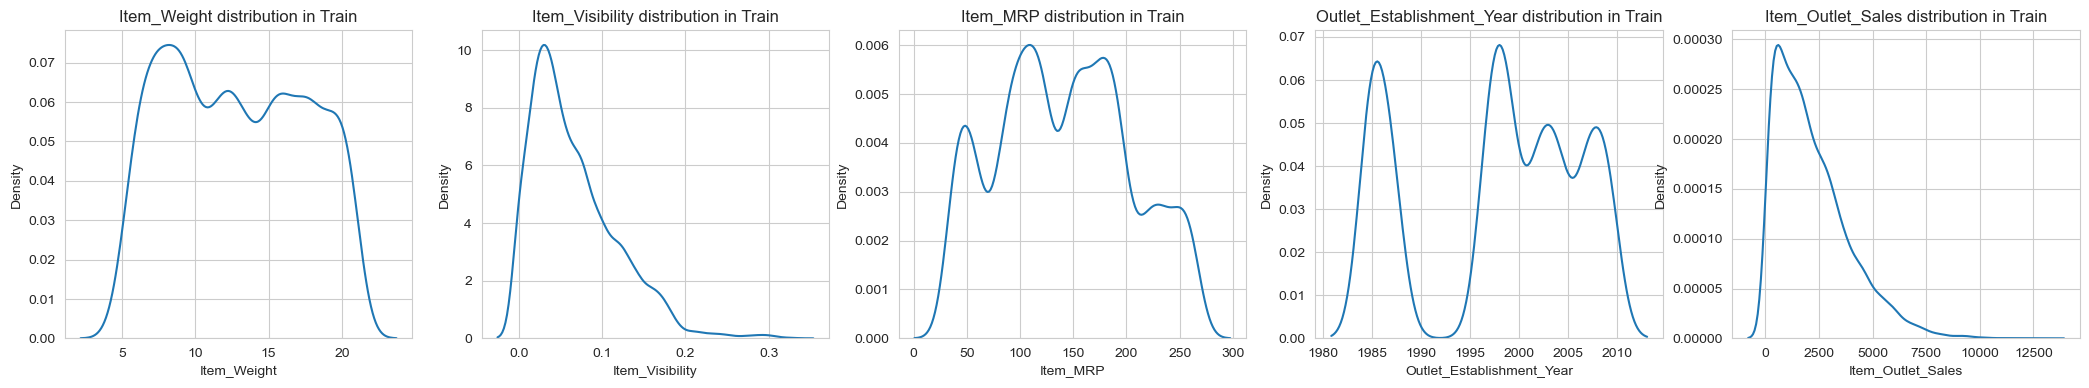

In [11]:
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(26, 4))

for index, col in enumerate(numeric_cols):
    sns.kdeplot(data=train, x=col, ax=ax[index])
    ax[index].set_title(f'{col} distribution in Train')

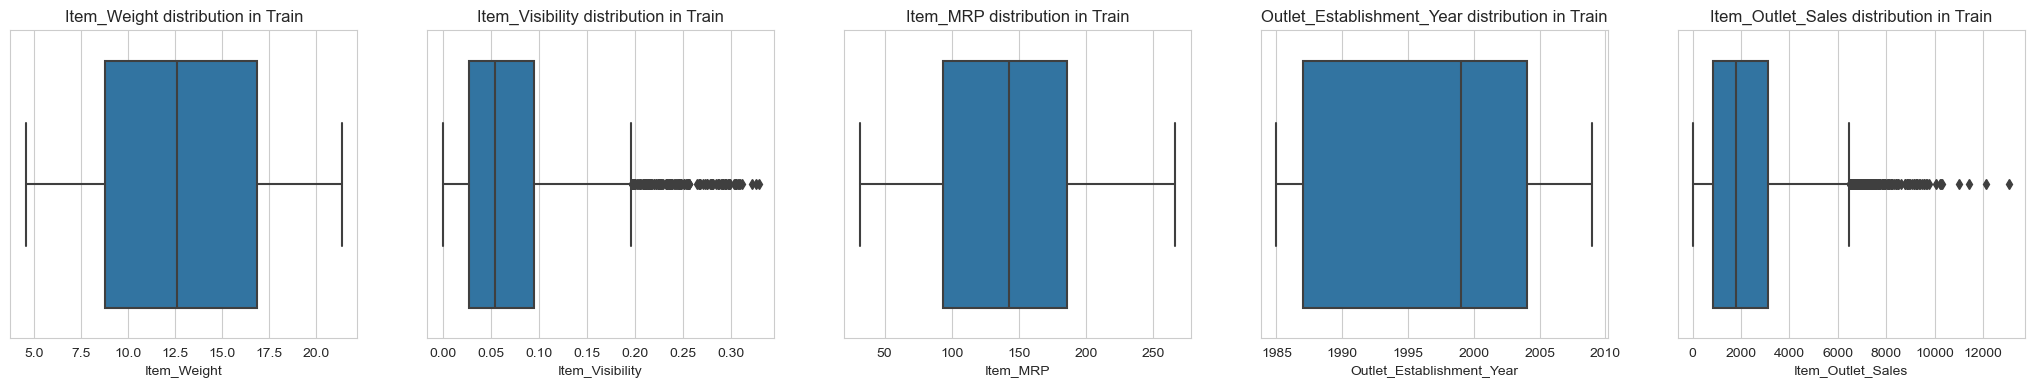

In [12]:
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(26, 4))

for index, col in enumerate(numeric_cols):
    sns.boxplot(data=train, x=col, ax=ax[index])
    ax[index].set_title(f'{col} distribution in Train')

In [13]:
### Categorical Variables
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
categorical_cols

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [14]:
for col in categorical_cols:
    print(f"Number of values in the {col} column is:\n{train[col].value_counts() }")
    print("--" * 30)

Number of values in the Item_Identifier column is:
Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: count, Length: 1559, dtype: int64
------------------------------------------------------------
Number of values in the Item_Fat_Content column is:
Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64
------------------------------------------------------------
Number of values in the Item_Type column is:
Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood

In [15]:
# sns.heatmap(train.corr(), annot=True)

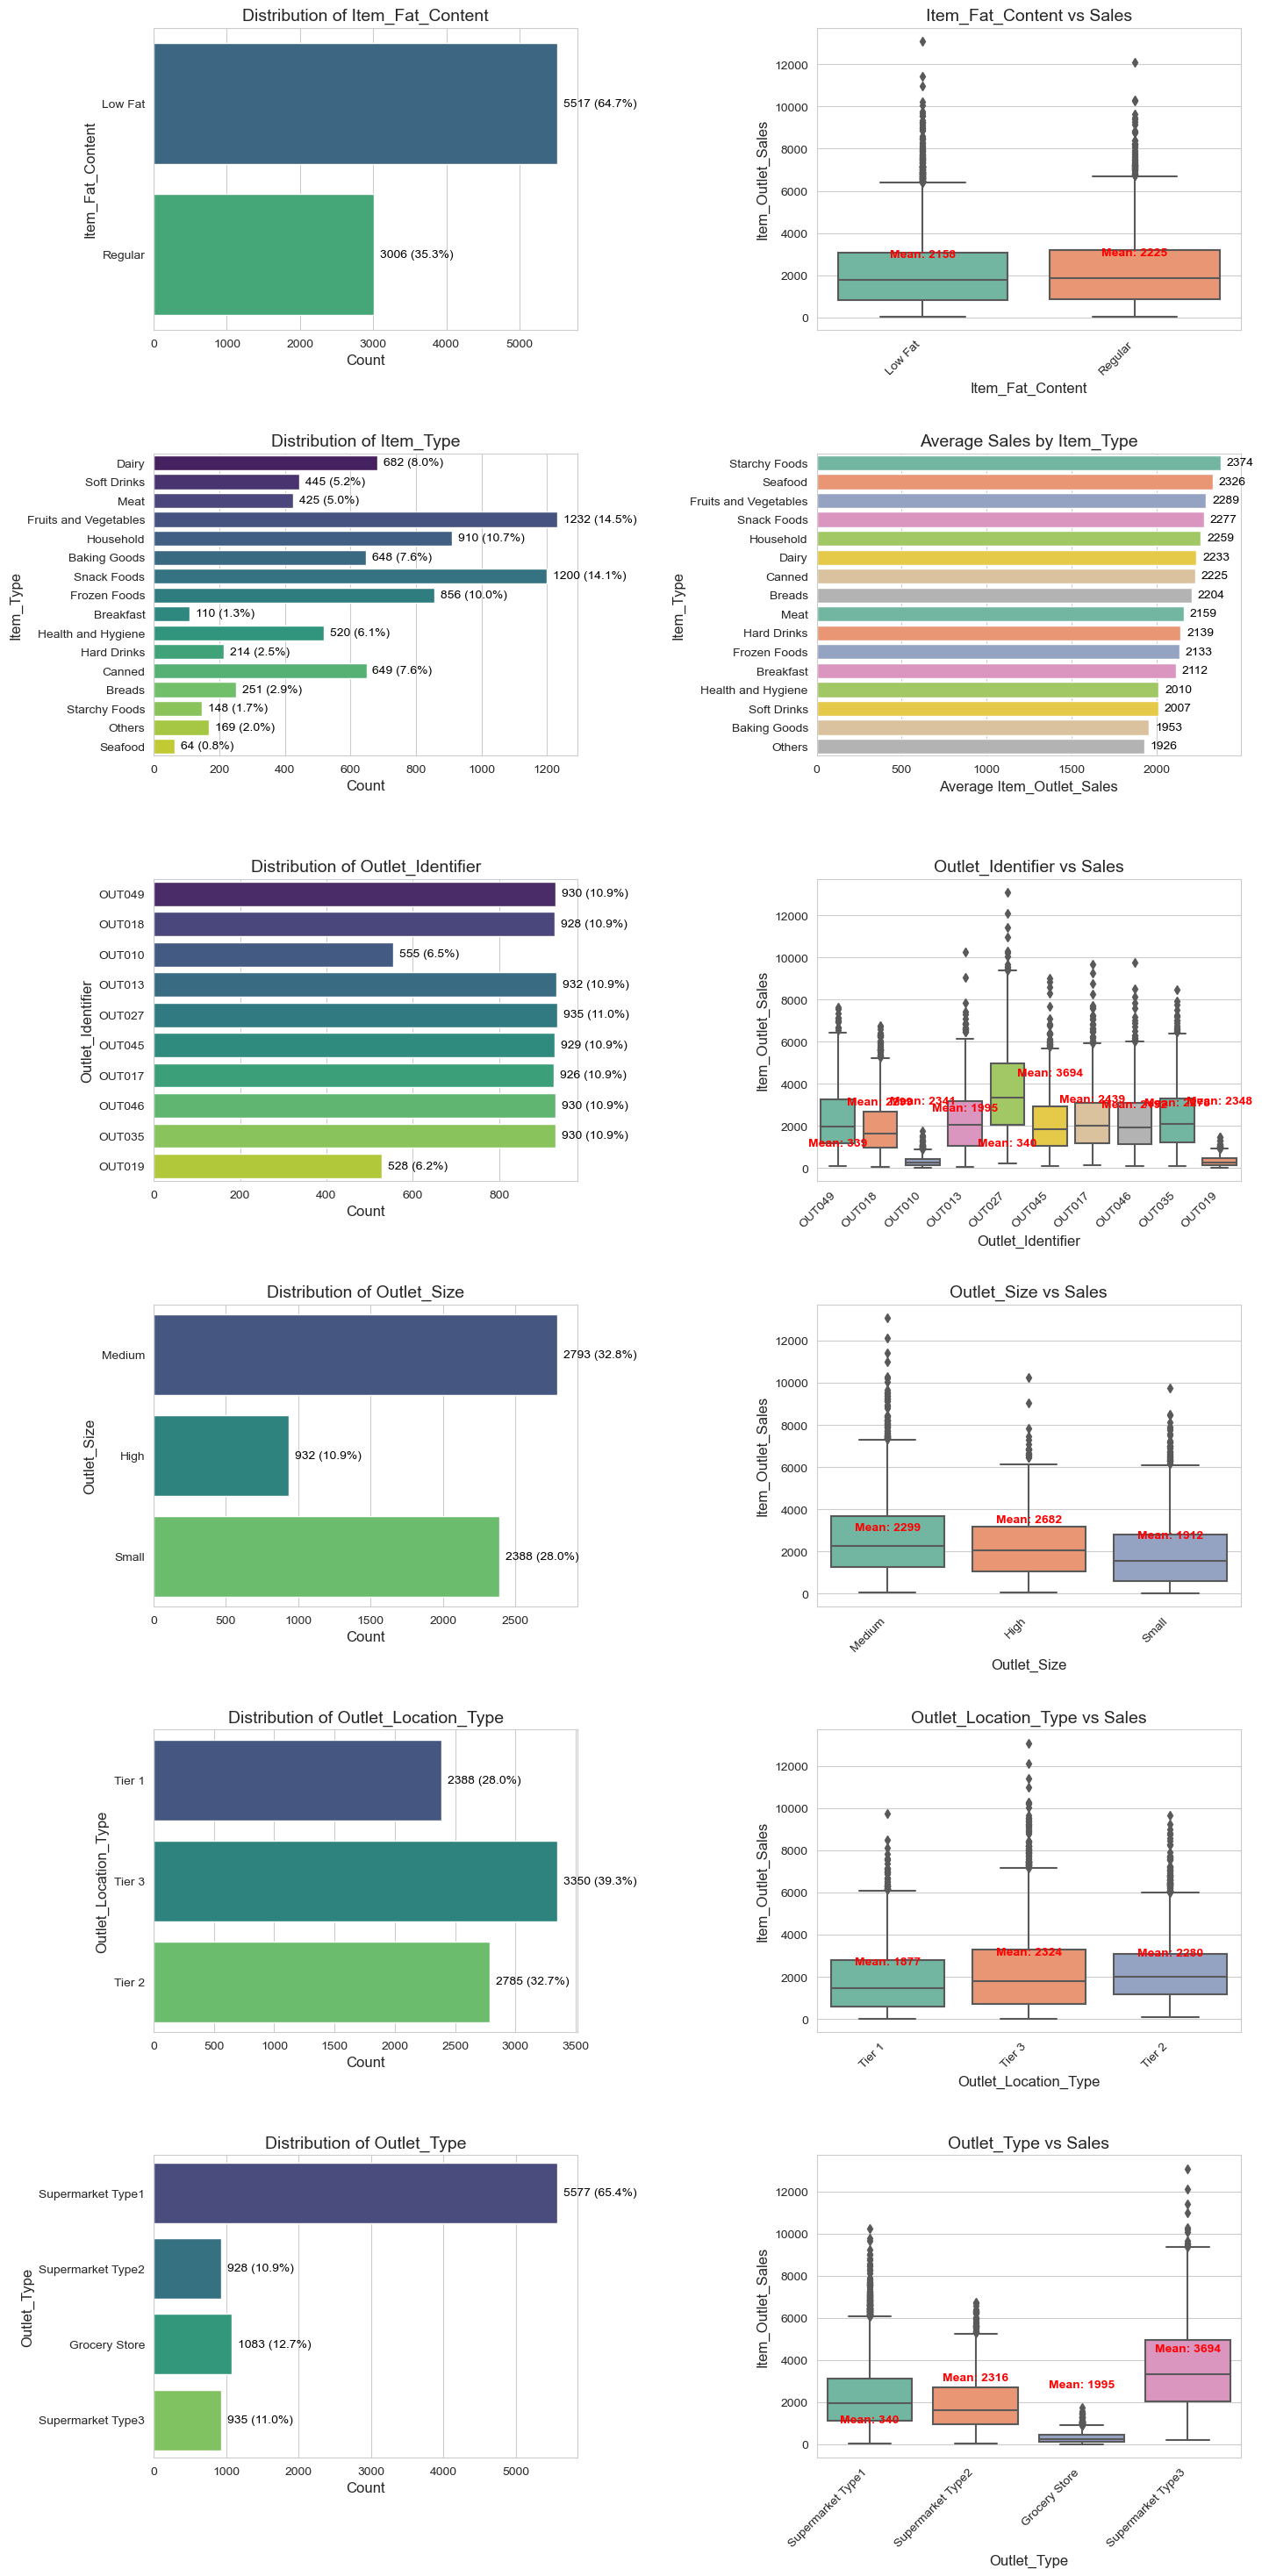

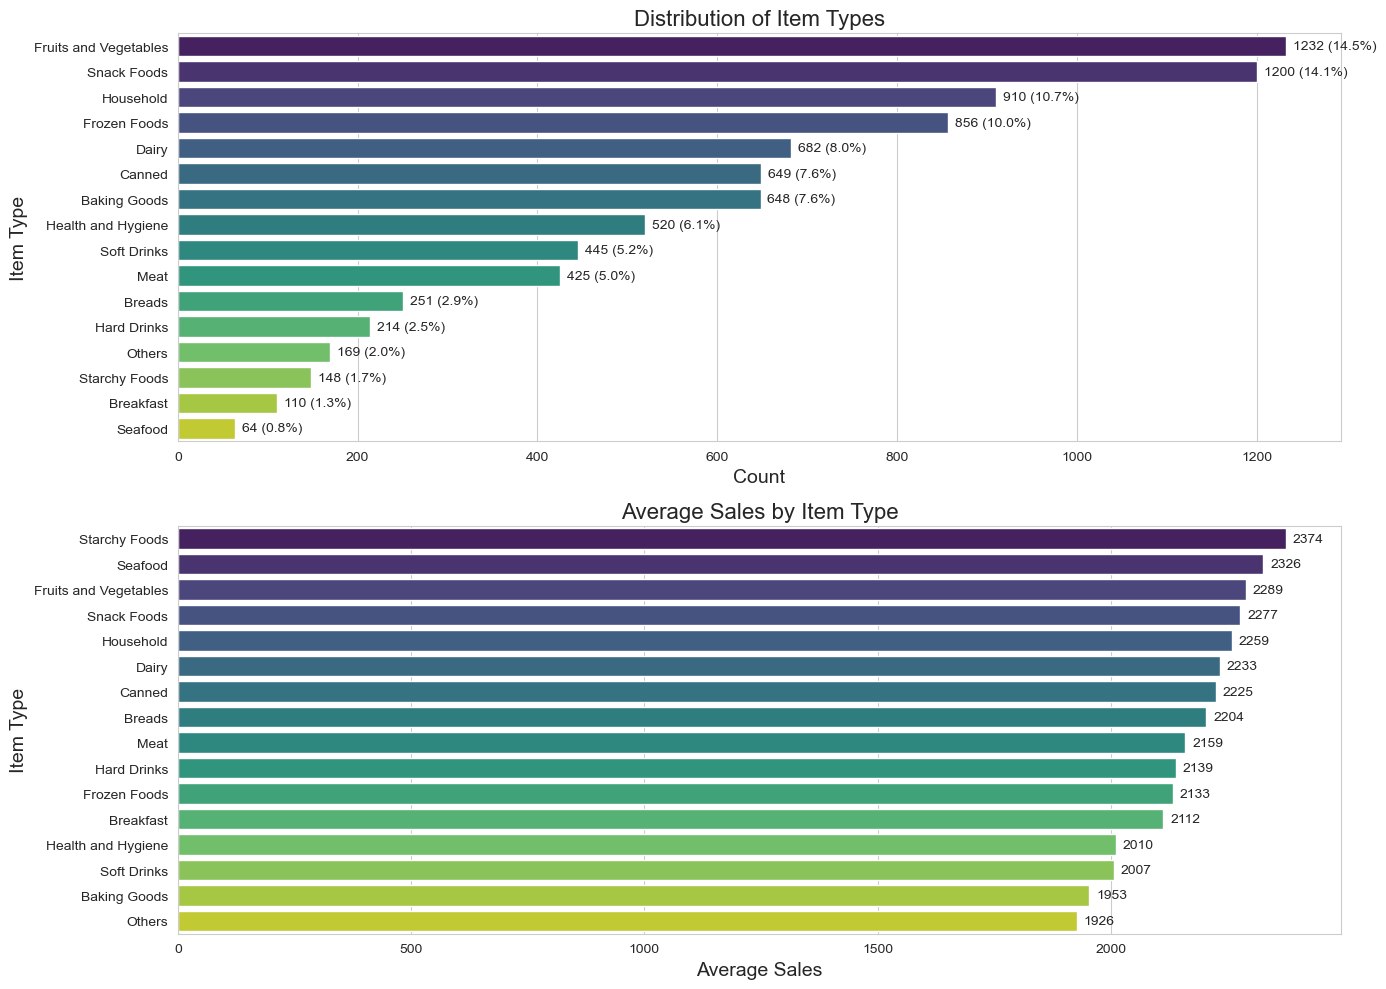

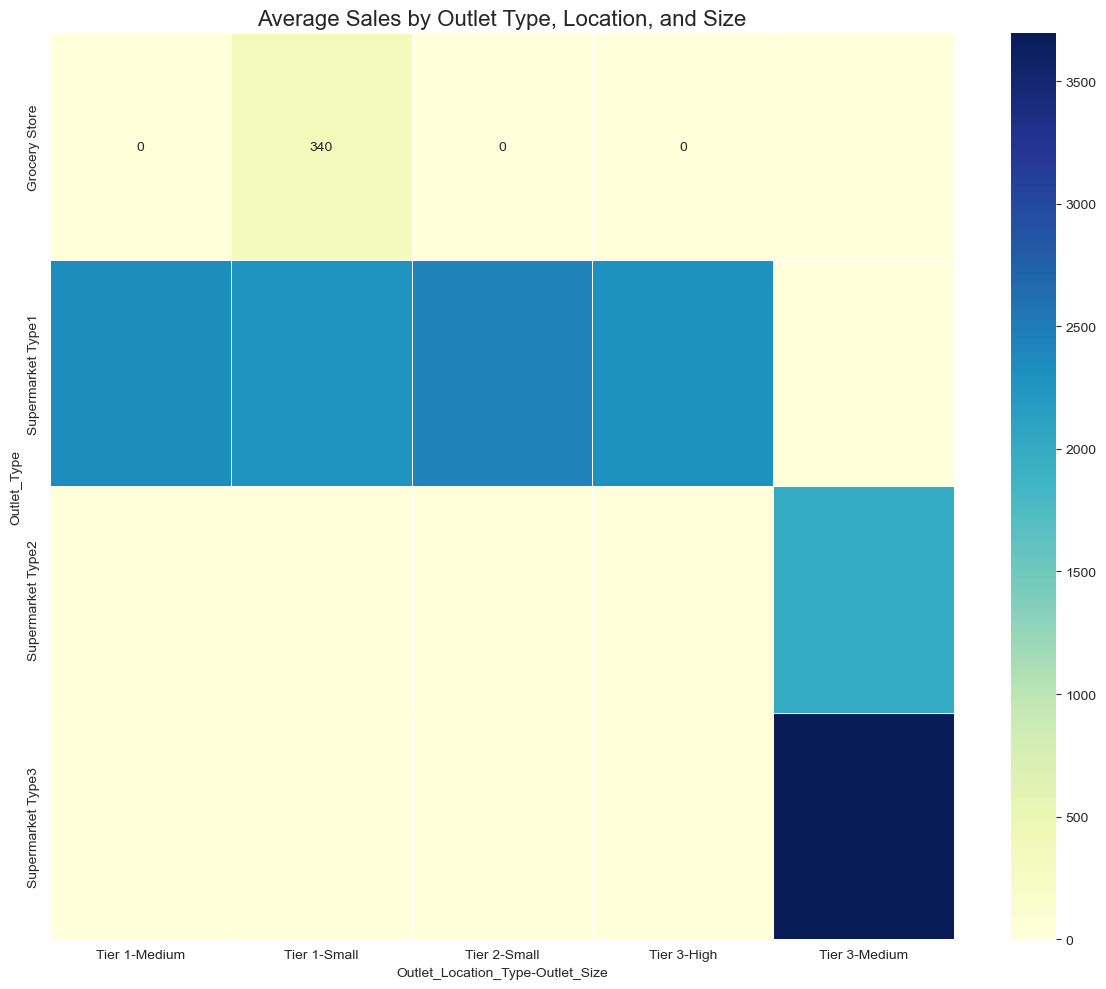

Unique values in categorical variables:

Item_Fat_Content (2 unique values):
  - Low Fat: 5517 occurrences (64.7%), Avg Sales: 2157.71
  - Regular: 3006 occurrences (35.3%), Avg Sales: 2224.56

Item_Type (16 unique values):
  - Dairy: 682 occurrences (8.0%), Avg Sales: 2232.54
  - Soft Drinks: 445 occurrences (5.2%), Avg Sales: 2006.51
  - Meat: 425 occurrences (5.0%), Avg Sales: 2158.98
  - Fruits and Vegetables: 1232 occurrences (14.5%), Avg Sales: 2289.01
  - Household: 910 occurrences (10.7%), Avg Sales: 2258.78
  - Baking Goods: 648 occurrences (7.6%), Avg Sales: 1952.97
  - Snack Foods: 1200 occurrences (14.1%), Avg Sales: 2277.32
  - Frozen Foods: 856 occurrences (10.0%), Avg Sales: 2132.87
  - Breakfast: 110 occurrences (1.3%), Avg Sales: 2111.81
  - Health and Hygiene: 520 occurrences (6.1%), Avg Sales: 2010.00
  - Hard Drinks: 214 occurrences (2.5%), Avg Sales: 2139.22
  - Canned: 649 occurrences (7.6%), Avg Sales: 2225.19
  - Breads: 251 occurrences (2.9%), Avg Sales: 2204.1

In [16]:
#### Categorical Variables understanding
# Identify categorical columns (excluding identifiers)
categorical_cols = [col for col in train.select_dtypes(include=['object']).columns 
                   if col not in ['Item_Identifier']]

# Standardize Item_Fat_Content values for better visualization
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace(
    {'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'})

# Create a figure with appropriate size based on number of categorical variables
num_plots = len(categorical_cols)
fig_height = num_plots * 5  # Adjust height based on number of plots
plt.figure(figsize=(15, fig_height))

# Create a count plot for each categorical variable
for i, col in enumerate(categorical_cols):
    plt.subplot(num_plots, 2, 2*i+1)
    
    # Count plot
    ax = sns.countplot(y=col, data=train, palette='viridis')
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel(col, fontsize=12)
    
    # Add count labels on bars
    for p in ax.patches:
        count = int(p.get_width())
        percentage = 100 * count / len(train)
        ax.annotate(f'{count} ({percentage:.1f}%)', 
                   (p.get_width(), p.get_y() + p.get_height()/2),
                   ha='left', va='center', fontsize=10, color='black',
                   xytext=(5, 0), textcoords='offset points')
    
    # Create a second plot to show the relationship with sales
    plt.subplot(num_plots, 2, 2*i+2)
    
    if len(train[col].unique()) <= 15:  # Use boxplot for variables with fewer categories
        sns.boxplot(x=col, y='Item_Outlet_Sales', data=train, palette='Set2')
        plt.title(f'{col} vs Sales', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Item_Outlet_Sales', fontsize=12)
        
        # Add average sales per category
        avg_sales = train.groupby(col)['Item_Outlet_Sales'].mean().reset_index()
        for j, (cat, avg) in enumerate(zip(avg_sales[col], avg_sales['Item_Outlet_Sales'])):
            x_pos = j
            plt.annotate(f'Mean: {avg:.0f}', xy=(x_pos, avg), 
                        ha='center', va='bottom', color='red', fontweight='bold',
                        xytext=(0, 10), textcoords='offset points')
    else:
        # For variables with many categories, use barplot of average sales
        avg_sales = train.groupby(col)['Item_Outlet_Sales'].mean().sort_values(ascending=False).reset_index()
        sns.barplot(x='Item_Outlet_Sales', y=col, data=avg_sales, palette='Set2')
        plt.title(f'Average Sales by {col}', fontsize=14)
        plt.xlabel('Average Item_Outlet_Sales', fontsize=12)
        plt.ylabel(col, fontsize=12)
        
        # Add average sales labels
        for p in plt.gca().patches:
            avg = p.get_width()
            plt.annotate(f'{avg:.0f}', 
                       (avg, p.get_y() + p.get_height()/2),
                       ha='left', va='center', fontsize=10, color='black',
                       xytext=(5, 0), textcoords='offset points')

plt.tight_layout(pad=3.0)
plt.savefig('categorical_variables_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a separate plot for Item_Type because it has many categories
plt.figure(figsize=(14, 10))

# Item type distribution
plt.subplot(2, 1, 1)
item_type_counts = train['Item_Type'].value_counts().sort_values(ascending=False)
sns.barplot(x=item_type_counts.values, y=item_type_counts.index, palette='viridis')
plt.title('Distribution of Item Types', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Item Type', fontsize=14)

# Add count and percentage labels
for i, (count, item_type) in enumerate(zip(item_type_counts.values, item_type_counts.index)):
    percentage = 100 * count / len(train)
    plt.annotate(f'{count} ({percentage:.1f}%)', 
               (count, i),
               ha='left', va='center', fontsize=10,
               xytext=(5, 0), textcoords='offset points')

# Average sales by item type
plt.subplot(2, 1, 2)
avg_sales_by_type = train.groupby('Item_Type')['Item_Outlet_Sales'].mean().sort_values(ascending=False)
sns.barplot(x=avg_sales_by_type.values, y=avg_sales_by_type.index, palette='viridis')
plt.title('Average Sales by Item Type', fontsize=16)
plt.xlabel('Average Sales', fontsize=14)
plt.ylabel('Item Type', fontsize=14)

# Add average sales labels
for i, avg in enumerate(avg_sales_by_type.values):
    plt.annotate(f'{avg:.0f}', 
               (avg, i),
               ha='left', va='center', fontsize=10,
               xytext=(5, 0), textcoords='offset points')

plt.tight_layout()
plt.savefig('item_type_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a heatmap to show relationships between categorical variables and average sales
plt.figure(figsize=(12, 10))

# We'll focus on three main categorical variables
heatmap_vars = ['Outlet_Type', 'Outlet_Location_Type', 'Outlet_Size']

# Create pivot table
pivot_data = train.pivot_table(
    values='Item_Outlet_Sales',
    index='Outlet_Type',
    columns=['Outlet_Location_Type', 'Outlet_Size'],
    aggfunc='mean',
    fill_value=0
)

# Plot heatmap
sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlGnBu', linewidths=0.5)
plt.title('Average Sales by Outlet Type, Location, and Size', fontsize=16)
plt.tight_layout()
plt.savefig('outlet_characteristics_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Print unique values for each categorical variable
print("Unique values in categorical variables:")
for col in categorical_cols:
    unique_vals = train[col].unique()
    print(f"\n{col} ({len(unique_vals)} unique values):")
    for val in unique_vals:
        count = (train[col] == val).sum()
        percentage = 100 * count / len(train)
        avg_sales = train[train[col] == val]['Item_Outlet_Sales'].mean()
        print(f"  - {val}: {count} occurrences ({percentage:.1f}%), Avg Sales: {avg_sales:.2f}")

#### Missing Value Treatment

Item Weight Variance - Original: 21.56168825983637
Item Weight Variance - Mean: 17.860121735060453
Item Weight Variance - Median: 17.869561454073366


<Axes: >

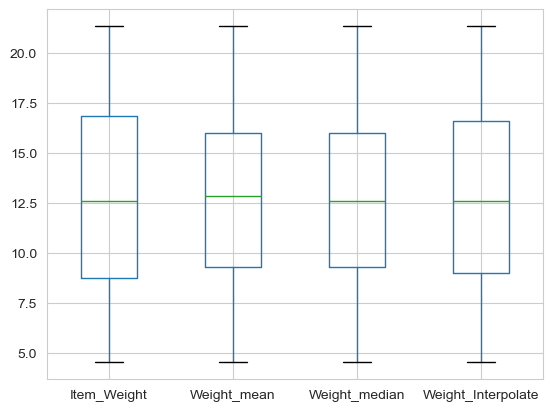

In [17]:
# 3.Handling Missing values in Item Size in training data
mean_wt=train['Item_Weight'].mean()
median_wt=train['Item_Weight'].median()
##Univariate Imputation
train['Weight_mean']=train['Item_Weight'].fillna(mean_wt)
train['Weight_median']=train['Item_Weight'].fillna(median_wt)

##Check for variance to choose the best method
print("Item Weight Variance - Original:", train['Item_Weight'].var())
print("Item Weight Variance - Mean:", train['Weight_mean'].var())
print("Item Weight Variance - Median:", train['Weight_median'].var())
## plot the item_weight in a line (original, mean, median, interpolation) - choose the best based on that for best interpolation
##Using Interpolate function - linear interpolation (missing values replaced based on neighbouring values)
train['Weight_Interpolate'] = train['Item_Weight'].interpolate(method ="linear")

train[['Item_Weight', 'Weight_mean', 'Weight_median','Weight_Interpolate']].boxplot()

Item Weight Variance - Original: 21.760812343231475
Item Weight Variance - Mean: 18.021630503971995
Item Weight Variance - Median: 18.027077062656364
Item Weight Variance - Interpolate: 19.990913374786285


<Axes: >

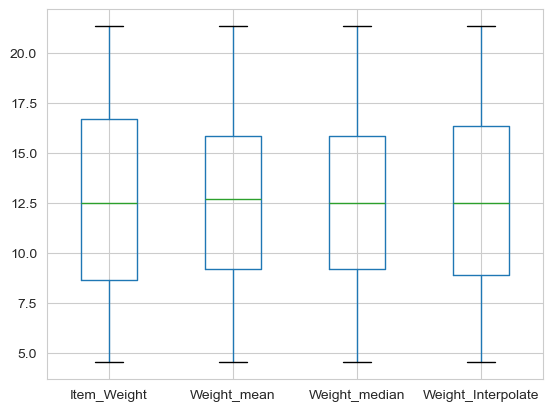

In [18]:
# 3.1Handling Missing values in Item Size in testing data
mean_wt_tst=test['Item_Weight'].mean()
median_wt_tst=test['Item_Weight'].median()
##Univariate Imputation
test['Weight_mean']=test['Item_Weight'].fillna(mean_wt_tst)
test['Weight_median']=test['Item_Weight'].fillna(median_wt_tst)

##Check for variance to choose the best method
print("Item Weight Variance - Original:", test['Item_Weight'].var())
print("Item Weight Variance - Mean:", test['Weight_mean'].var())
print("Item Weight Variance - Median:", test['Weight_median'].var())

## plot the item_weight in a line (original, mean, median, interpolation) - choose the best based on that for best interpolation
##Using Interpolate function - linear interpolation (missing values replaced based on neighbouring values)
test['Weight_Interpolate'] = test['Item_Weight'].interpolate(method ="linear")
print("Item Weight Variance - Interpolate:", test['Weight_Interpolate'].var())
test[['Item_Weight', 'Weight_mean', 'Weight_median','Weight_Interpolate']].boxplot()

In [19]:
train = train.drop(['Weight_mean','Weight_median','Item_Weight'],axis=1)
test = test.drop(['Weight_mean','Weight_median','Item_Weight'],axis=1)
print(train.isnull().sum())

Item_Identifier                 0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
Weight_Interpolate              0
dtype: int64


In [20]:
train['Outlet_Size']  #it is a categorical value

0       Medium
1       Medium
2       Medium
3          NaN
4         High
         ...  
8518      High
8519       NaN
8520     Small
8521    Medium
8522     Small
Name: Outlet_Size, Length: 8523, dtype: object

In [21]:
train['Outlet_Size'].value_counts()

Outlet_Size
Medium    2793
Small     2388
High       932
Name: count, dtype: int64

In [22]:
train['Outlet_Size'].mode()

0    Medium
Name: Outlet_Size, dtype: object

In [23]:
## 4. Handle Missing Values -Outlet Size --Train Data
print(train['Outlet_Size'].value_counts())
print(train['Outlet_Type'].value_counts())
print(train['Outlet_Location_Type'].value_counts())

mode_store = train.pivot_table(values='Outlet_Size',columns='Outlet_Type',aggfunc=(lambda x:x.mode()[0]))
print(mode_store)

missing_values = train['Outlet_Size'].isnull()

train.loc[missing_values,'Outlet_Size'] = train.loc[missing_values,'Outlet_Type'].apply(lambda x :mode_store[x])

Outlet_Size
Medium    2793
Small     2388
High       932
Name: count, dtype: int64
Outlet_Type
Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: count, dtype: int64
Outlet_Location_Type
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: count, dtype: int64
Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


In [24]:
train.isnull().sum()

Item_Identifier              0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
Weight_Interpolate           0
dtype: int64

In [25]:
## 4.2 Handle Missing Values -Outlet Size --Test Data
print(test['Outlet_Size'].value_counts())
print(test['Outlet_Type'].value_counts())
print(test['Outlet_Location_Type'].value_counts())

mode_store = test.pivot_table(values='Outlet_Size',columns='Outlet_Type',aggfunc=(lambda x:x.mode()[0]))
print(mode_store)

missing_values = test['Outlet_Size'].isnull()

test.loc[missing_values,'Outlet_Size'] = test.loc[missing_values,'Outlet_Type'].apply(lambda x :mode_store[x])

Outlet_Size
Medium    1862
Small     1592
High       621
Name: count, dtype: int64
Outlet_Type
Supermarket Type1    3717
Grocery Store         722
Supermarket Type3     624
Supermarket Type2     618
Name: count, dtype: int64
Outlet_Location_Type
Tier 3    2233
Tier 2    1856
Tier 1    1592
Name: count, dtype: int64
Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


#### Feature Engineering

In [26]:
####Outlier treatment for Item Visibility & Item Outlet Sales
# Function to detect outliers using IQR
def detect_outliers(df, column):
    # Calculate Q1, Q3, and IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    print(f"\nOutlier Analysis for {column}:")
    print(f"Q1: {Q1:.4f}")
    print(f"Q3: {Q3:.4f}")
    print(f"IQR: {IQR:.4f}")
    print(f"Lower bound: {lower_bound:.4f}")
    print(f"Upper bound: {upper_bound:.4f}")
    print(f"Number of outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}% of data)")
    
    return outliers, lower_bound, upper_bound


Outlier Analysis for Item_Visibility:
Q1: 0.0270
Q3: 0.0946
IQR: 0.0676
Lower bound: -0.0744
Upper bound: 0.1960
Number of outliers: 144 (1.69% of data)

Outlier Analysis for Item_Outlet_Sales:
Q1: 834.2474
Q3: 3101.2964
IQR: 2267.0490
Lower bound: -2566.3261
Upper bound: 6501.8699
Number of outliers: 186 (2.18% of data)


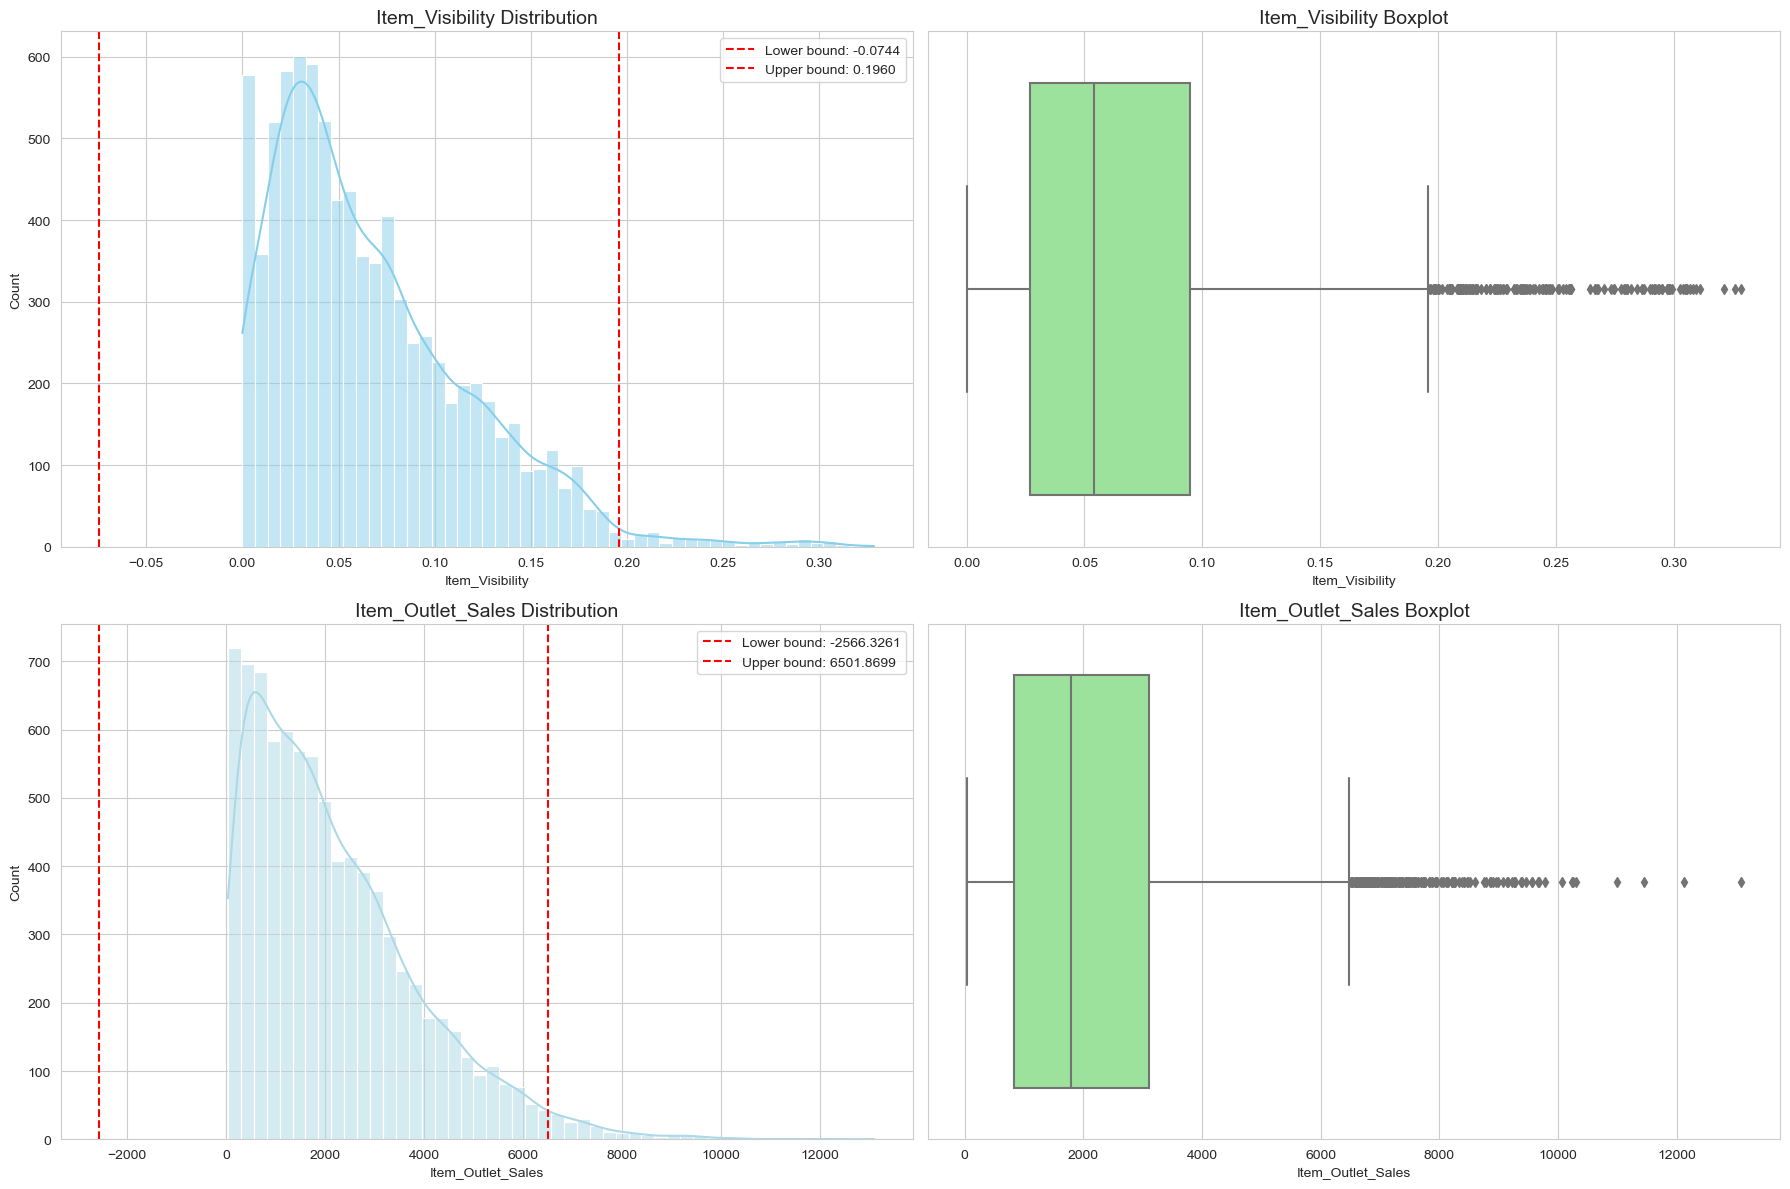


Total number of rows with outliers in either variable: 330 (3.87% of data)

Sample of visibility outliers:
    Item_Identifier Item_Fat_Content  Item_Visibility              Item_Type  \
49            FDS02          Regular         0.255395                  Dairy   
83            NCL18          Low Fat         0.293418              Household   
108           DRE60          Low Fat         0.278974            Soft Drinks   
174           FDI32          Low Fat         0.291865  Fruits and Vegetables   
334           FDC41          Low Fat         0.204700           Frozen Foods   

     Item_MRP Outlet_Identifier  Outlet_Establishment_Year Outlet_Size  \
49   196.8794            OUT019                       1985       Small   
83   194.6136            OUT019                       1985       Small   
108  225.3720            OUT019                       1985       Small   
174  115.1834            OUT010                       1998       Small   
334   76.8670            OUT019          

In [27]:
# Visualize original distribution with outliers highlighted
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Item_Visibility outliers
axes[0, 0].set_title("Item_Visibility Distribution", fontsize=14)
sns.histplot(train['Item_Visibility'], bins=50, kde=True, ax=axes[0, 0], color='skyblue')

outliers_visibility, lower_bound_vis, upper_bound_vis = detect_outliers(train, 'Item_Visibility')
axes[0, 0].axvline(lower_bound_vis, color='red', linestyle='--', label=f'Lower bound: {lower_bound_vis:.4f}')
axes[0, 0].axvline(upper_bound_vis, color='red', linestyle='--', label=f'Upper bound: {upper_bound_vis:.4f}')
axes[0, 0].legend()

# Item_Visibility boxplot
axes[0, 1].set_title("Item_Visibility Boxplot", fontsize=14)
sns.boxplot(x=train['Item_Visibility'], ax=axes[0, 1], color='lightgreen')

# Item_Outlet_Sales outliers
axes[1, 0].set_title("Item_Outlet_Sales Distribution", fontsize=14)
sns.histplot(train['Item_Outlet_Sales'], bins=50, kde=True, ax=axes[1, 0], color='lightblue')

outliers_sales, lower_bound_sales, upper_bound_sales = detect_outliers(train, 'Item_Outlet_Sales')
axes[1, 0].axvline(lower_bound_sales, color='red', linestyle='--', label=f'Lower bound: {lower_bound_sales:.4f}')
axes[1, 0].axvline(upper_bound_sales, color='red', linestyle='--', label=f'Upper bound: {upper_bound_sales:.4f}')
axes[1, 0].legend()

# Item_Outlet_Sales boxplot
axes[1, 1].set_title("Item_Outlet_Sales Boxplot", fontsize=14)
sns.boxplot(x=train['Item_Outlet_Sales'], ax=axes[1, 1], color='lightgreen')

plt.tight_layout()
plt.savefig('outlier_detection.png', dpi=300, bbox_inches='tight')
plt.show()

# Get outliers indices for both variables
outlier_indices_visibility = outliers_visibility.index
outlier_indices_sales = outliers_sales.index

# Find all unique outlier indices
all_outlier_indices = list(set(list(outlier_indices_visibility) + list(outlier_indices_sales)))

print(f"\nTotal number of rows with outliers in either variable: {len(all_outlier_indices)} ({len(all_outlier_indices)/len(train)*100:.2f}% of data)")

# Examine some outliers
print("\nSample of visibility outliers:")
print(outliers_visibility.head())

print("\nSample of sales outliers:")
print(outliers_sales.head())


Shape after removing outliers: (8193, 12)
Removed 330 rows (3.87% of data)


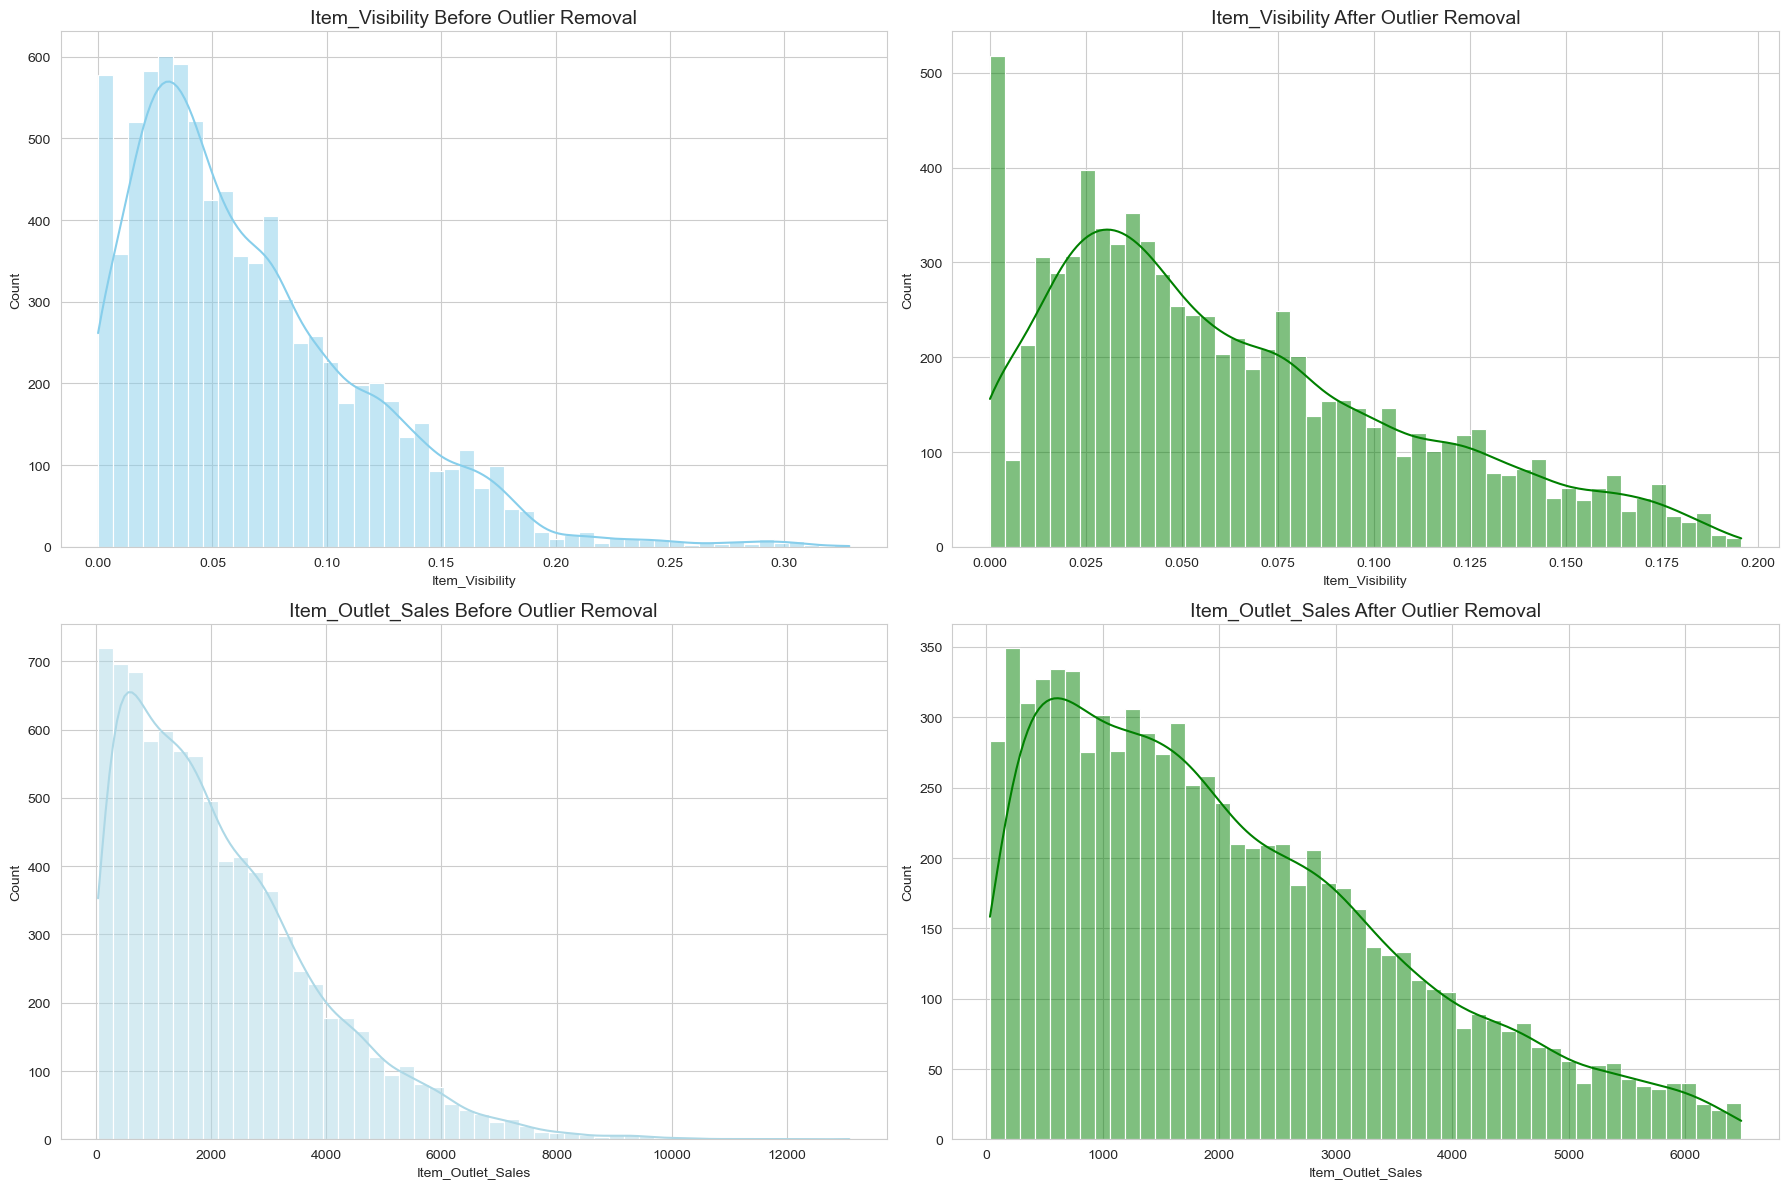


Statistics before outlier removal:
       Item_Visibility  Item_Outlet_Sales
count      8523.000000        8523.000000
mean          0.066132        2181.288914
std           0.051598        1706.499616
min           0.000000          33.290000
25%           0.026989         834.247400
50%           0.053931        1794.331000
75%           0.094585        3101.296400
max           0.328391       13086.964800

Statistics after outlier removal:
       Item_Visibility  Item_Outlet_Sales
count      8193.000000        8193.000000
mean          0.063221        2089.540121
std           0.046285        1501.498356
min           0.000000          33.290000
25%           0.026818         857.550400
50%           0.052729        1783.678200
75%           0.092783        3020.068800
max           0.195721        6478.234000

Cleaned dataset saved as 'train_no_outliers.csv'


In [28]:
# Remove outliers
train_no_outliers = train.drop(all_outlier_indices)
print(f"\nShape after removing outliers: {train_no_outliers.shape}")
print(f"Removed {len(train) - len(train_no_outliers)} rows ({(len(train) - len(train_no_outliers))/len(train)*100:.2f}% of data)")

# Visualize distributions after removing outliers
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Original vs cleaned Item_Visibility distribution
axes[0, 0].set_title("Item_Visibility Before Outlier Removal", fontsize=14)
sns.histplot(train['Item_Visibility'], bins=50, kde=True, ax=axes[0, 0], color='skyblue')

axes[0, 1].set_title("Item_Visibility After Outlier Removal", fontsize=14)
sns.histplot(train_no_outliers['Item_Visibility'], bins=50, kde=True, ax=axes[0, 1], color='green')

# Original vs cleaned Item_Outlet_Sales distribution
axes[1, 0].set_title("Item_Outlet_Sales Before Outlier Removal", fontsize=14)
sns.histplot(train['Item_Outlet_Sales'], bins=50, kde=True, ax=axes[1, 0], color='lightblue')

axes[1, 1].set_title("Item_Outlet_Sales After Outlier Removal", fontsize=14)
sns.histplot(train_no_outliers['Item_Outlet_Sales'], bins=50, kde=True, ax=axes[1, 1], color='green')

plt.tight_layout()
plt.savefig('before_after_outlier_removal.png', dpi=300, bbox_inches='tight')
plt.show()

# Check statistics before and after outlier removal
print("\nStatistics before outlier removal:")
print(train[['Item_Visibility', 'Item_Outlet_Sales']].describe())

print("\nStatistics after outlier removal:")
print(train_no_outliers[['Item_Visibility', 'Item_Outlet_Sales']].describe())

# Save the cleaned dataset
train_no_outliers.to_csv('train_no_outliers.csv', index=False)
print("\nCleaned dataset saved as 'train_no_outliers.csv'")

# Create a new function to detect and visualize outliers in test data
def detect_visualize_testdata_outliers():
    # Load test data
    test = pd.read_csv('test_AbJTz2l.csv')
    print(f"\nTest dataset shape: {test.shape}")
    
    # Detect Item_Visibility outliers in test data
    test_outliers_visibility, test_lower_bound_vis, test_upper_bound_vis = detect_outliers(test, 'Item_Visibility')
    
    # Visualize test data outliers
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Test Data: Item_Visibility Distribution", fontsize=14)
    sns.histplot(test['Item_Visibility'], bins=50, kde=True, color='purple')
    plt.axvline(test_lower_bound_vis, color='red', linestyle='--', label=f'Lower bound: {test_lower_bound_vis:.4f}')
    plt.axvline(test_upper_bound_vis, color='red', linestyle='--', label=f'Upper bound: {test_upper_bound_vis:.4f}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.title("Test Data: Item_Visibility Boxplot", fontsize=14)
    sns.boxplot(x=test['Item_Visibility'], color='violet')
    
    plt.tight_layout()
    plt.savefig('test_data_outliers.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print test outlier summary
    print(f"\nTotal number of outliers in test data: {len(test_outliers_visibility)} ({len(test_outliers_visibility)/len(test)*100:.2f}% of test data)")
    
    # Return for further processing if needed
    return test, test_outliers_visibility

# Uncomment to analyze test data outliers
# test_data, test_outliers = detect_visualize_testdata_outliers()

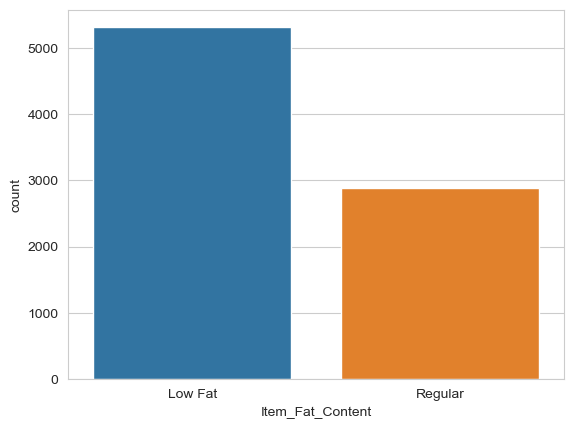

In [29]:
# Normalize Item_Fat_Content values
fat_content_map = {
    'Low Fat': 'Low Fat',
    'Regular': 'Regular',
    'LF': 'Low Fat',
    'low fat': 'Low Fat',
    'reg': 'Regular'
}
train_no_outliers['Item_Fat_Content'] = train_no_outliers['Item_Fat_Content'].map(fat_content_map)
test['Item_Fat_Content'] = test['Item_Fat_Content'].map(fat_content_map)
sns.countplot(x=train_no_outliers['Item_Fat_Content']);

In [30]:
# Calculate outlet age
import datetime as dt
current_year = dt.datetime.today().year
print(current_year)
train_no_outliers['Outlet_Years'] = 2025 - train_no_outliers['Outlet_Establishment_Year']
test['Outlet_Years'] = 2025 - test['Outlet_Establishment_Year']
del train_no_outliers['Outlet_Establishment_Year']
del test['Outlet_Establishment_Year']

2025


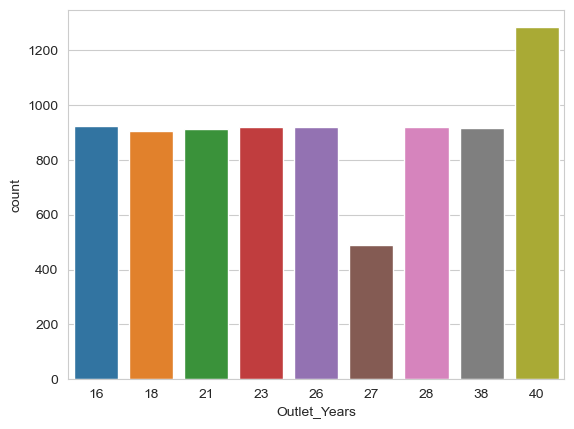

In [31]:
sns.countplot(x=train_no_outliers['Outlet_Years']);

#### Handling Categorical Variables [Feature Encoding]

In [32]:
test['Outlet_Size'].value_counts()

Outlet_Size
Small     3198
Medium    1862
High       621
Name: count, dtype: int64

In [33]:
###Label Encoding - Outlet Size
train_no_outliers['Outlet_Size'] = train_no_outliers['Outlet_Size'].map({'Small'  : 1,
                                                 'Medium' : 2,
                                                 'High'   : 3
                                                 }).astype(int)

test['Outlet_Size'] = test['Outlet_Size'].map({'Small'  : 1,
                                               'Medium' : 2,
                                               'High'   : 3
                                              }).astype(int)

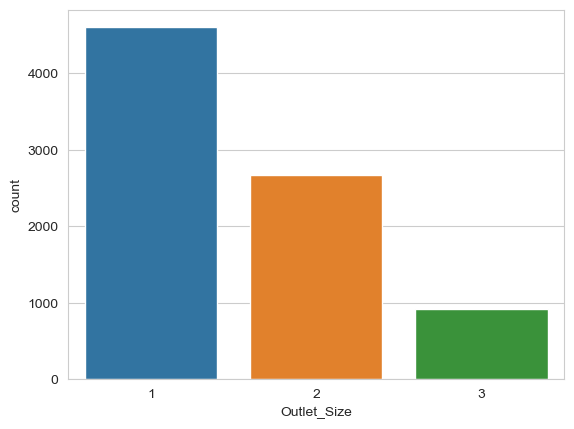

In [34]:
sns.countplot(x=train_no_outliers['Outlet_Size']);

<Axes: xlabel='Outlet_Location_Type', ylabel='count'>

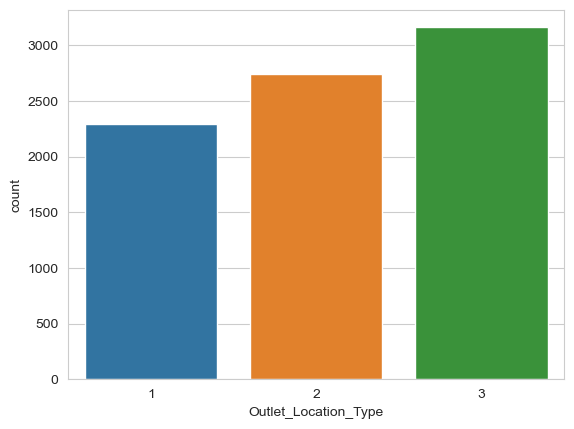

In [35]:
# Label Encoding - Outlet Location Type: Tier1, Tier 2, Tier 3 can be made as 1,2,3 by splitting the string in names

train_no_outliers['Outlet_Location_Type'] = train_no_outliers['Outlet_Location_Type'].str[-1:].astype(int)
test['Outlet_Location_Type']  = test['Outlet_Location_Type'].str[-1:].astype(int)
sns.countplot(x=train_no_outliers['Outlet_Location_Type'])

In [36]:
# Extract item category from Item_Identifier
train_no_outliers['Item_Category'] = train_no_outliers['Item_Identifier'].str[:2]


###test Data
test['Item_Category'] = test['Item_Identifier'].str[:2]


# Let's drop useless columns
train_no_outliers.drop(labels=['Item_Identifier'], axis=1, inplace=True)
test_ids=test['Item_Identifier']
test.drop(labels=['Item_Identifier'],  axis=1, inplace=True)

In [37]:

test_outlets=test['Outlet_Identifier']
test.head()

,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Weight_Interpolate,Outlet_Years,Item_Category
0,Low Fat,0.007565,Snack Foods,107.8622,OUT049,2,1,Supermarket Type1,20.7500,26,FD
1,Regular,0.038428,Dairy,87.3198,OUT017,1,2,Supermarket Type1,8.3000,18,FD
2,Low Fat,0.099575,Others,241.7538,OUT010,1,3,Grocery Store,14.6000,27,NC
3,Low Fat,0.015388,Snack Foods,155.0340,OUT017,1,2,Supermarket Type1,7.3150,18,FD
4,Regular,0.118599,Dairy,234.2300,OUT027,2,3,Supermarket Type3,8.5575,40,FD


<Axes: xlabel='Item_Category', ylabel='count'>

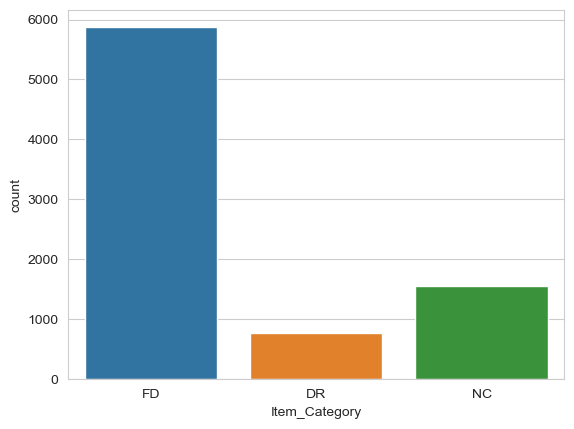

In [38]:
sns.countplot(x=train_no_outliers['Item_Category'])

In [39]:
# Label Encoding for Categorical Variables - Fat Content, Outlet Type and Location Type
encoder = LabelEncoder()
ord_features = ['Item_Fat_Content', 'Outlet_Type', 'Outlet_Location_Type']

for feature in ord_features:
    train_no_outliers[feature] = encoder.fit_transform(train_no_outliers[feature])
    test[feature]  = encoder.fit_transform(test[feature])

train_no_outliers.shape

(8193, 12)

In [40]:
# One Hot Encoding for 'Item_Type', Item Category, Outlet variable

train_no_outliers = pd.get_dummies(train_no_outliers, columns=['Item_Type', 'Item_Category', 'Outlet_Identifier'], drop_first=True)
test  = pd.get_dummies(test,  columns=['Item_Type', 'Item_Category', 'Outlet_Identifier'], drop_first=True)

In [41]:
train_no_outliers.shape

(8193, 35)

In [42]:
print(test.isnull().sum())

Item_Fat_Content                   0
Item_Visibility                    0
Item_MRP                           0
Outlet_Size                        0
Outlet_Location_Type               0
Outlet_Type                        0
Weight_Interpolate                 0
Outlet_Years                       0
Item_Type_Breads                   0
Item_Type_Breakfast                0
Item_Type_Canned                   0
Item_Type_Dairy                    0
Item_Type_Frozen Foods             0
Item_Type_Fruits and Vegetables    0
Item_Type_Hard Drinks              0
Item_Type_Health and Hygiene       0
Item_Type_Household                0
Item_Type_Meat                     0
Item_Type_Others                   0
Item_Type_Seafood                  0
Item_Type_Snack Foods              0
Item_Type_Soft Drinks              0
Item_Type_Starchy Foods            0
Item_Category_FD                   0
Item_Category_NC                   0
Outlet_Identifier_OUT013           0
Outlet_Identifier_OUT017           0
O

In [43]:
###Data Pre-processing
##After the columns are already dropped, create X & y from training data
X = train_no_outliers.drop('Item_Outlet_Sales', axis=1)
y = train_no_outliers['Item_Outlet_Sales']

In [44]:
X.head()

,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Weight_Interpolate,Outlet_Years,Item_Type_Breads,Item_Type_Breakfast,...,Item_Category_NC,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,0,0.016047,249.8092,2,0,1,9.30,26,False,False,...,False,False,False,False,False,False,False,False,False,True
1,1,0.019278,48.2692,2,2,2,5.92,16,False,False,...,False,False,False,True,False,False,False,False,False,False
2,0,0.016760,141.6180,2,0,1,17.50,26,False,False,...,False,False,False,False,False,False,False,False,False,True
3,1,0.000000,182.0950,1,2,0,19.20,27,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,0.000000,53.8614,3,2,1,8.93,38,False,False,...,True,True,False,False,False,False,False,False,False,False


In [45]:
y.head()

0    3735.1380
1     443.4228
2    2097.2700
3     732.3800
4     994.7052
Name: Item_Outlet_Sales, dtype: float64

In [46]:
###Split to train and test from X&y - 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [47]:
###Linear Regression
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)
# Predictions for LinearRegression on the test data
lin_reg_predictions = lin_reg_model.predict(X_test)

In [48]:
print('Training score  : {}'.format(lin_reg_model.score(X_train, y_train)))
print('Test score      : {}'.format(lin_reg_model.score(X_test, y_test)))

Training score  : 0.5516817311885018
Test score      : 0.5471561668556967


In [49]:
# Evaluation
lin_reg_mse  = mean_squared_error(y_test , lin_reg_predictions)
lin_reg_rmse = math.sqrt(lin_reg_mse)
lin_reg_r2   = r2_score(y_test, lin_reg_predictions)

print('RMSE  \t         ----> {}'.format(lin_reg_rmse))
print('R2 Score         ----> {}'.format(lin_reg_r2))

RMSE  	         ----> 1021.5402698128889
R2 Score         ----> 0.5471561668556967


Model Performance Comparison:
                                Train R²   Test R²    Test RMSE
Baseline (Linear Regression)    0.551682  0.547156  1021.540270
Polynomial Features             0.599812  0.566976   998.934769
Feature Selection               0.551110  0.547992  1020.597120
Polynomial + Feature Selection  0.550756  0.547715  1020.909737
Ridge Regression                0.599812  0.566977   998.933472

Best parameters: {'feature_selection__k': 25, 'poly__degree': 3, 'regression__alpha': 1.0}
Best RMSE: 1002.5174709272471

Best Model Test Results:
Test RMSE: 1012.8869
Test R² Score: 0.5548


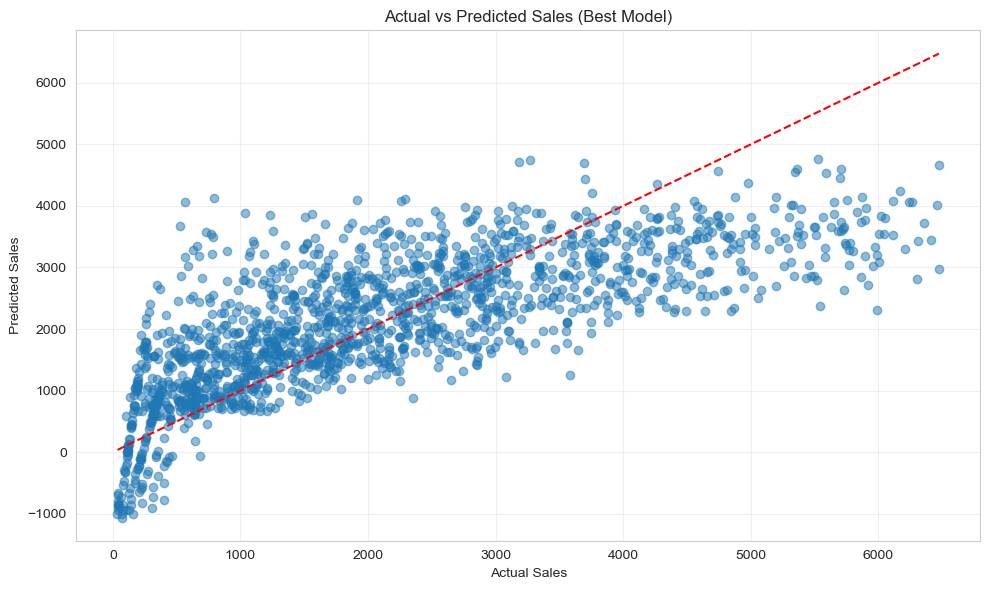

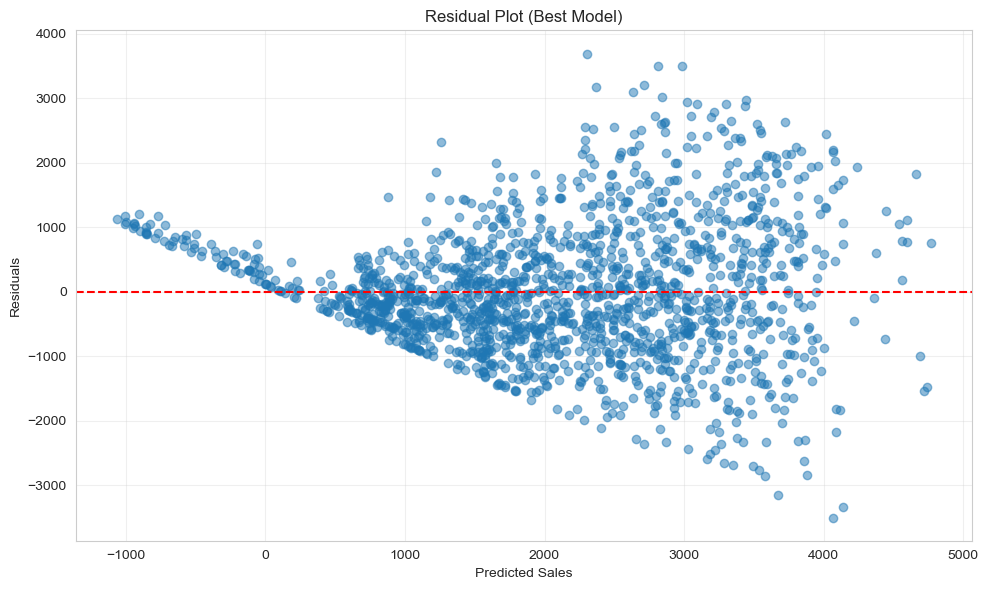

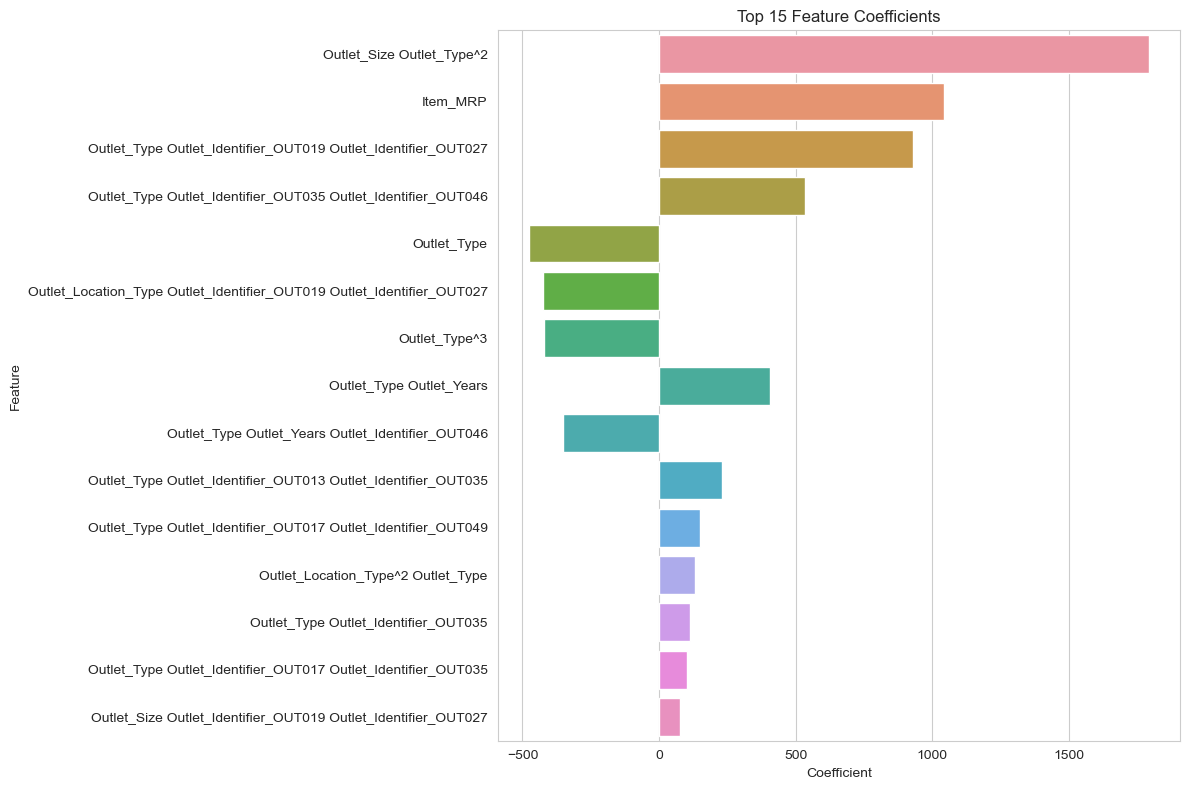

In [50]:
####try using steps and pipelines for 
## 1. Standard Scaler
## 2. Polynomial setup
## 3. Feature Selection 
## 4. Advanced pipeline with polynomial features and feature selection
## 5. Ridge Regression 
## 6. Train all & evaluate which is the best
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
# 1. Create a baseline linear regression model with standardization
baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regression', LinearRegression())
])

# 2. Create pipeline with polynomial features
poly_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('regression', LinearRegression())
])

# 3. Create pipeline with feature selection
feature_select_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_regression)),
    ('regression', LinearRegression())
])

# 4. Create advanced pipeline with polynomial features and feature selection
advanced_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('feature_selection', SelectKBest(f_regression)),
    ('regression', LinearRegression())
])

# 5. Create pipeline with regularization (Ridge)
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('regression', Ridge())
])

# 6. Train and evaluate all pipelines
pipelines = {
    'Baseline (Linear Regression)': baseline_pipeline,
    'Polynomial Features': poly_pipeline,
    'Feature Selection': feature_select_pipeline,
    'Polynomial + Feature Selection': advanced_pipeline,
    'Ridge Regression': ridge_pipeline
}

results = {}

for name, pipeline in pipelines.items():
    # For polynomial pipelines, let's try degree=2
    if 'poly' in pipeline.named_steps:
        pipeline.named_steps['poly'].degree = 2
    
    # For feature selection pipelines, let's try k=20 features
    if 'feature_selection' in pipeline.named_steps:
        pipeline.named_steps['feature_selection'].k = 20
    
    # For ridge pipeline, set alpha
    if 'Ridge' in str(pipeline.named_steps['regression']):
        pipeline.named_steps['regression'].alpha = 0.1
        
    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    
    # Predictions
    train_pred = pipeline.predict(X_train)
    test_pred = pipeline.predict(X_test)
    
    # Scores
    train_score = r2_score(y_train, train_pred)
    test_score = r2_score(y_test, test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    
    # Store results
    results[name] = {
        'Train R²': train_score,
        'Test R²': test_score,
        'Test RMSE': test_rmse
    }

# Convert results to DataFrame for easy comparison
results_df = pd.DataFrame(results).T
print("Model Performance Comparison:")
print(results_df)

# Let's fine-tune the best model using GridSearchCV
# Assuming Polynomial + Ridge is promising based on initial results
param_grid = {
    'poly__degree': [2, 3],
    'feature_selection__k': [10, 15, 20, 25],
    'regression__alpha': [0.01, 0.1, 1.0, 10.0]
}

ridge_tuning_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('feature_selection', SelectKBest(f_regression)),
    ('regression', Ridge())
])

# Parameter grid for the complete pipeline
param_grid = {
    'poly__degree': [2, 3],
    'feature_selection__k': [10, 15, 20, 25],
    'regression__alpha': [0.01, 0.1, 1.0, 10.0]
}

# Create and run the grid search
grid_search = GridSearchCV(
    ridge_tuning_pipeline,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

# Run the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters
print("\nBest parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)

# Test the best model
best_model = grid_search.best_estimator_
best_pred = best_model.predict(X_test)
best_rmse = np.sqrt(mean_squared_error(y_test, best_pred))
best_r2 = r2_score(y_test, best_pred)

print("\nBest Model Test Results:")
print(f"Test RMSE: {best_rmse:.4f}")
print(f"Test R² Score: {best_r2:.4f}")

# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales (Best Model)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('actual_vs_predicted.png', dpi=300)
plt.show()

# Plot residuals
residuals = y_test - best_pred
plt.figure(figsize=(10, 6))
plt.scatter(best_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.title('Residual Plot (Best Model)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('residuals.png', dpi=300)
plt.show()

# Calculate feature importances for best model (if using linear model)
if hasattr(best_model[-1], 'coef_'):
    # Get feature names after transformations
    if 'poly' in best_model.named_steps:
        poly = best_model.named_steps['poly']
        feature_names = poly.get_feature_names_out(X_train.columns)
    else:
        feature_names = X_train.columns
        
    # If feature selection was used, we need to get the selected feature indices
    if 'feature_selection' in best_model.named_steps:
        feature_selector = best_model.named_steps['feature_selection']
        selected_indices = feature_selector.get_support(indices=True)
        feature_names = [feature_names[i] for i in selected_indices]
    
    # Get coefficients
    coefficients = best_model[-1].coef_
    
    # Create a DataFrame with feature names and their coefficients
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })
    
    # Sort by absolute coefficient values
    feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
    feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)
    
    # Plot the top 15 features
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    sns.barplot(x='Coefficient', y='Feature', data=top_features)
    plt.title('Top 15 Feature Coefficients')
    plt.tight_layout()
    plt.savefig('feature_coefficients.png', dpi=300)
    plt.show()

In [51]:
# Make predictions on test data
test_predictions = best_model.predict(test)

In [52]:
# Prepare submission file
submission = pd.DataFrame({
    'Item_Identifier': test_ids,
    'Outlet_Identifier': test_outlets,
    'Item_Outlet_Sales': test_predictions
})

In [53]:
# Export submission to CSV
submission.to_csv('bigmart_sales_prediction7.csv', index=False)
print("\nSubmission file created successfully!")


Submission file created successfully!


In [54]:
###Lasso
steps = [
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2)),
            ('model', Lasso(alpha=0.2, fit_intercept=True))
        ]

lasso_pipeline = Pipeline(steps)

lasso_pipeline.fit(X_train, y_train)

print('Training score  : {}'    .format(lasso_pipeline.score(X_train, y_train)))
print('Test score      : {}'    .format(lasso_pipeline.score(X_test, y_test)))

Training score  : 0.5997739980816841
Test score      : 0.5674969373936971


In [55]:
# Predictions for Lasso on the testset
lasso_predictions = lasso_pipeline.predict(X_test)

In [59]:
# Evaluation
lasso_mse  = mean_squared_error(y_test , lasso_predictions)
lasso_rmse = math.sqrt(lasso_mse)
lasso_r2   = r2_score(y_test, lasso_predictions)

print('Lasso RMSE  \t         ----> {}'.format(lasso_rmse))
print('Lasso R2 Score         ----> {}'.format(lasso_r2))

Lasso RMSE  	         ----> 998.3339864105521
Lasso R2 Score         ----> 0.5674969373936971


In [56]:
# Make predictions on test data
test_predictions = lasso_pipeline.predict(test)

In [57]:
submission = pd.DataFrame({
    'Item_Identifier': test_ids,
    'Outlet_Identifier': test_outlets,
    'Item_Outlet_Sales': test_predictions
})

In [58]:
# Export submission to CSV
submission.to_csv('bigmart_sales_prediction8.csv', index=False)
print("\nSubmission file created successfully!")


Submission file created successfully!


In [90]:
##### Random Forest #####
rf_model = RandomForestRegressor(n_estimators=1000)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000)

In [91]:
# Predictions for RF on the test data
rf_predictions = rf_model.predict(X_test)

In [92]:
print('Training score  : {}'.format(rf_model.score(X_train, y_train)))
print('Test score      : {}'.format(rf_model.score(X_test, y_test)))

Training score  : 0.937457489329373
Test score      : 0.5266794032220105


In [93]:
# Evaluation
rf_mse = mean_squared_error(y_test , rf_predictions)
rf_rmse = math.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_predictions)

print('RandomForest RMSE  \t       ----> {}'.format(rf_rmse))
print('RandomForest R2 Score       ----> {}'.format(rf_r2))

RandomForest RMSE  	       ----> 1044.3810047715722
RandomForest R2 Score       ----> 0.5266794032220105


In [94]:
# Make predictions on test data
test_predictions = rf_model.predict(test)

In [95]:
test_predictions

array([1841.6347584, 1425.4897844,  635.000092 , ..., 1861.024186 ,
       4525.8633856, 1529.988426 ])

In [96]:
submission = pd.DataFrame({
    'Item_Identifier': test_ids,
    'Outlet_Identifier': test_outlets,
    'Item_Outlet_Sales': test_predictions
})
# Export submission to CSV
submission.to_csv('bigmart_sales_prediction14.csv', index=False)
print("\nSubmission file created successfully!")
submission


Submission file created successfully!


,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1841.634758
1,FDW14,OUT017,1425.489784
2,NCN55,OUT010,635.000092
3,FDQ58,OUT017,2266.144844
4,FDY38,OUT027,3972.243362
...,...,...,...
5676,FDB58,OUT046,2351.471108
5677,FDD47,OUT018,3531.387887
5678,NCO17,OUT045,1861.024186
5679,FDJ26,OUT017,4525.863386


In [69]:
###### XGB Model ###
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [70]:
# Predictions for XGBoost on the test data
xgb_predictions = xgb_model.predict(X_test)

In [71]:
print('XGBoost Training score  : {}'.format(xgb_model.score(X_train, y_train)))
print('XGBoost Test score      : {}'.format(xgb_model.score(X_test, y_test)))

XGBoost Training score  : 0.8606562429022797
XGBoost Test score      : 0.48432858112230537


In [72]:
# Evaluation
xgb_mse = mean_squared_error(y_test , xgb_predictions)
xgb_rmse = math.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, xgb_predictions)

print('XGBoost RMSE  \t   ----> {}'.format(xgb_rmse))
print('XGBoost R2 Score   ----> {}'.format(xgb_r2))

XGBoost RMSE  	   ----> 1090.1036484827123
XGBoost R2 Score   ----> 0.48432858112230537


In [73]:
# Make predictions on test data
test_predictions = xgb_model.predict(test)
submission = pd.DataFrame({
    'Item_Identifier': test_ids,
    'Outlet_Identifier': test_outlets,
    'Item_Outlet_Sales': test_predictions
})
# Export submission to CSV
submission.to_csv('bigmart_sales_prediction10.csv', index=False)
print("\nSubmission file created successfully!")
submission


Submission file created successfully!


,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1657.732544
1,FDW14,OUT017,1338.250000
2,NCN55,OUT010,1077.329712
3,FDQ58,OUT017,2414.046875
4,FDY38,OUT027,3018.471680
...,...,...,...
5676,FDB58,OUT046,2402.393799
5677,FDD47,OUT018,3463.562012
5678,NCO17,OUT045,2044.406006
5679,FDJ26,OUT017,4900.802246


In [78]:
start = time.time()

Training baseline Random Forest model...
Baseline Random Forest - Train R²: 0.9354
Baseline Random Forest - Test R²: 0.5205
Baseline Random Forest - Test RMSE: 1051.1586

Performing RandomizedSearchCV for Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
RandomizedSearchCV completed in 169.47 seconds

Best parameters from RandomizedSearchCV:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10}
Best RMSE: 984.8596

Fine-tuning Random Forest with GridSearchCV...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
GridSearchCV completed in 272.95 seconds

Best parameters from GridSearchCV:
{'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 250}
Best RMSE: 1002.6417

Optimized Random Forest Results:
Train R²: 0.6861
Test R²: 0.5531
Test RMSE: 1014.8348

Top 10 most important features (Random Forest):
                     Feature  Importance
2  

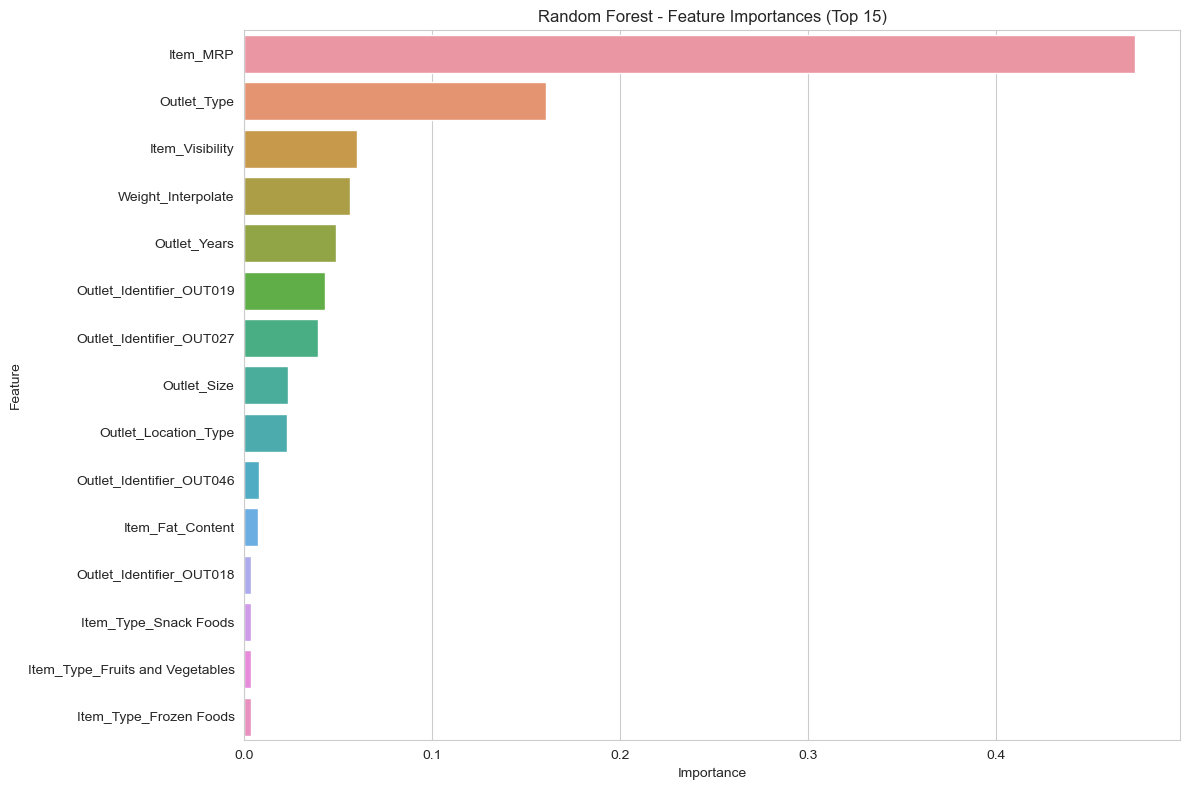

In [79]:
###### Random Forest Fine tuning #####
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import time
# Step 1: Initial Random Forest with default parameters as baseline
print("Training baseline Random Forest model...")
rf_default = RandomForestRegressor(random_state=42)
rf_default.fit(X_train, y_train)

# Evaluate baseline model
rf_default_train_pred = rf_default.predict(X_train)
rf_default_test_pred = rf_default.predict(X_test)

rf_default_train_r2 = r2_score(y_train, rf_default_train_pred)
rf_default_test_r2 = r2_score(y_test, rf_default_test_pred)
rf_default_test_rmse = np.sqrt(mean_squared_error(y_test, rf_default_test_pred))

print(f"Baseline Random Forest - Train R²: {rf_default_train_r2:.4f}")
print(f"Baseline Random Forest - Test R²: {rf_default_test_r2:.4f}")
print(f"Baseline Random Forest - Test RMSE: {rf_default_test_rmse:.4f}")

# Step 2: Use RandomizedSearchCV for initial parameter exploration
print("\nPerforming RandomizedSearchCV for Random Forest...")
rf_param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=rf_param_dist,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

start = time.time()
rf_random.fit(X_train, y_train)
print(f"RandomizedSearchCV completed in {time.time() - start:.2f} seconds")

print("\nBest parameters from RandomizedSearchCV:")
print(rf_random.best_params_)
print(f"Best RMSE: {-rf_random.best_score_:.4f}")

# Step 3: Fine-tune with GridSearchCV around the best parameters
print("\nFine-tuning Random Forest with GridSearchCV...")
# Create more focused parameter grid based on RandomizedSearchCV results
best_n_estimators = rf_random.best_params_['n_estimators']
best_max_depth = rf_random.best_params_['max_depth']
best_min_samples_split = rf_random.best_params_['min_samples_split']
best_min_samples_leaf = rf_random.best_params_['min_samples_leaf']
best_max_features = rf_random.best_params_['max_features']

rf_param_grid = {
    'n_estimators': [best_n_estimators - 50, best_n_estimators, best_n_estimators + 50],
    'max_depth': [best_max_depth - 5 if best_max_depth is not None and best_max_depth > 5 else None, 
                  best_max_depth, 
                  best_max_depth + 5 if best_max_depth is not None else None],
    'min_samples_split': [max(2, best_min_samples_split - 2), best_min_samples_split, best_min_samples_split + 2],
    'min_samples_leaf': [max(1, best_min_samples_leaf - 1), best_min_samples_leaf, best_min_samples_leaf + 1],
    'max_features': [best_max_features]
}

# Remove None values from the grid to avoid errors
for param, values in rf_param_grid.items():
    rf_param_grid[param] = [v for v in values if v is not None]
    if not rf_param_grid[param]:  # If list became empty, add a default
        if param == 'max_depth':
            rf_param_grid[param] = [None]
        elif param == 'max_features':
            rf_param_grid[param] = ['sqrt']

rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=rf_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

start = time.time()
rf_grid.fit(X_train, y_train)
print(f"GridSearchCV completed in {time.time() - start:.2f} seconds")

print("\nBest parameters from GridSearchCV:")
print(rf_grid.best_params_)
print(f"Best RMSE: {-rf_grid.best_score_:.4f}")

# Step 4: Evaluate final Random Forest model
rf_best = rf_grid.best_estimator_
rf_best_train_pred = rf_best.predict(X_train)
rf_best_test_pred = rf_best.predict(X_test)

rf_best_train_r2 = r2_score(y_train, rf_best_train_pred)
rf_best_test_r2 = r2_score(y_test, rf_best_test_pred)
rf_best_test_rmse = np.sqrt(mean_squared_error(y_test, rf_best_test_pred))

print("\nOptimized Random Forest Results:")
print(f"Train R²: {rf_best_train_r2:.4f}")
print(f"Test R²: {rf_best_test_r2:.4f}")
print(f"Test RMSE: {rf_best_test_rmse:.4f}")

# Feature importance for Random Forest
rf_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_best.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 most important features (Random Forest):")
print(rf_feature_importance.head(10))

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=rf_feature_importance.head(15))
plt.title('Random Forest - Feature Importances (Top 15)')
plt.tight_layout()
plt.savefig('rf_feature_importance.png', dpi=300)
plt.show()

In [80]:
# Make predictions on test data
test_predictions = rf_random.predict(test)
submission = pd.DataFrame({
    'Item_Identifier': test_ids,
    'Outlet_Identifier': test_outlets,
    'Item_Outlet_Sales': test_predictions
})
# Export submission to CSV
submission.to_csv('bigmart_sales_prediction11.csv', index=False)
print("\nSubmission file created successfully!")
submission


Submission file created successfully!


,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1780.829768
1,FDW14,OUT017,1387.298756
2,NCN55,OUT010,619.984187
3,FDQ58,OUT017,2381.294521
4,FDY38,OUT027,4141.824310
...,...,...,...
5676,FDB58,OUT046,2337.941342
5677,FDD47,OUT018,3264.249902
5678,NCO17,OUT045,1816.145707
5679,FDJ26,OUT017,3874.833889




Training baseline XGBoost model...
Baseline XGBoost - Train R²: 0.8607
Baseline XGBoost - Test R²: 0.4843
Baseline XGBoost - Test RMSE: 1090.1036

Performing RandomizedSearchCV for XGBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
RandomizedSearchCV completed in 19.26 seconds

Best parameters from RandomizedSearchCV:
{'subsample': 0.9, 'reg_lambda': 3, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.9}
Best RMSE: 972.2568

Fine-tuning XGBoost with GridSearchCV...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
GridSearchCV (learning rate & n_estimators) completed in 5.31 seconds

Best parameters from first GridSearchCV:
{'learning_rate': 0.030000000000000002, 'n_estimators': 200}
Best RMSE: 968.3201
Fitting 5 folds for each of 27 candidates, totalling 135 fits
GridSearchCV (tree parameters) completed in 14.78 seconds

Best parameters from second GridSearchCV:
{'ga

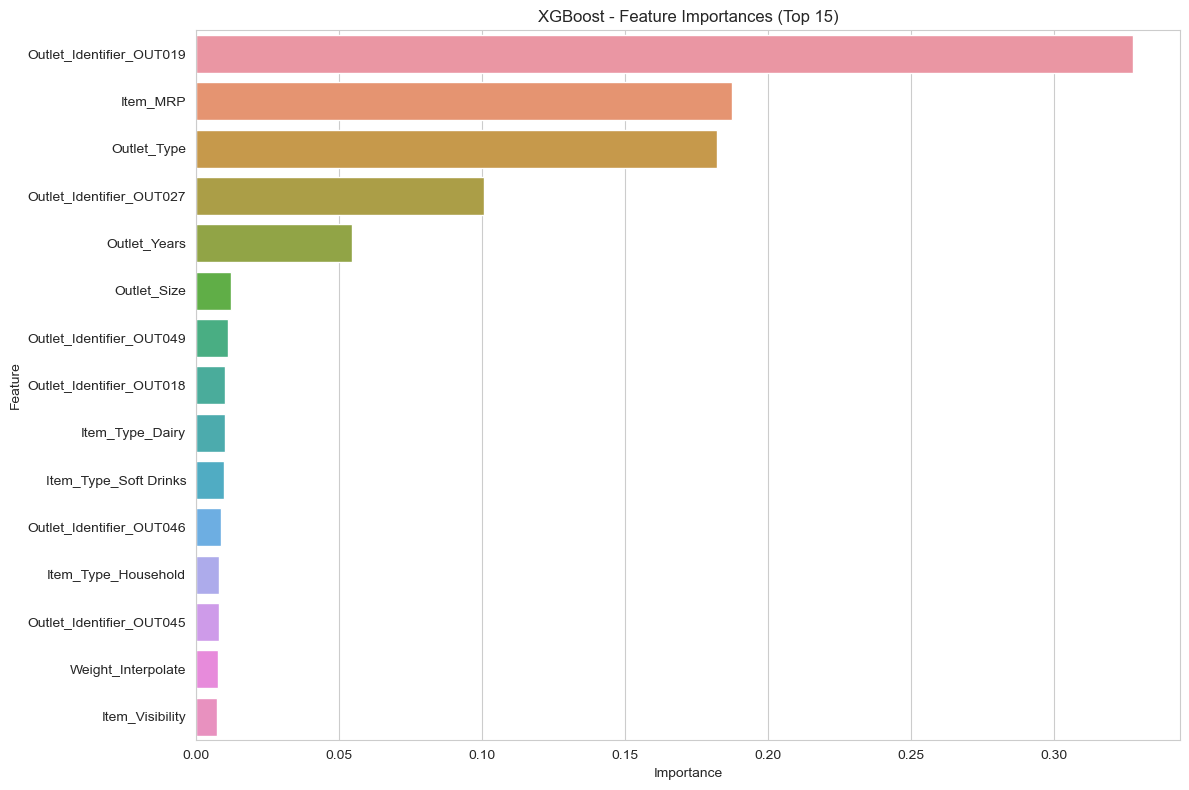


=============== MODEL COMPARISON ===============
                     Model  Train R²   Test R²    Test RMSE
0        Linear Regression  0.552000  0.547000  1021.500000
1             Ridge (Poly)  0.600000  0.567000   998.900000
2  Random Forest (Default)  0.935375  0.520516  1051.158605
3    Random Forest (Tuned)  0.686051  0.553082  1014.834847
4        XGBoost (Default)  0.860656  0.484329  1090.103648
5          XGBoost (Tuned)  0.598972  0.579220   984.710696


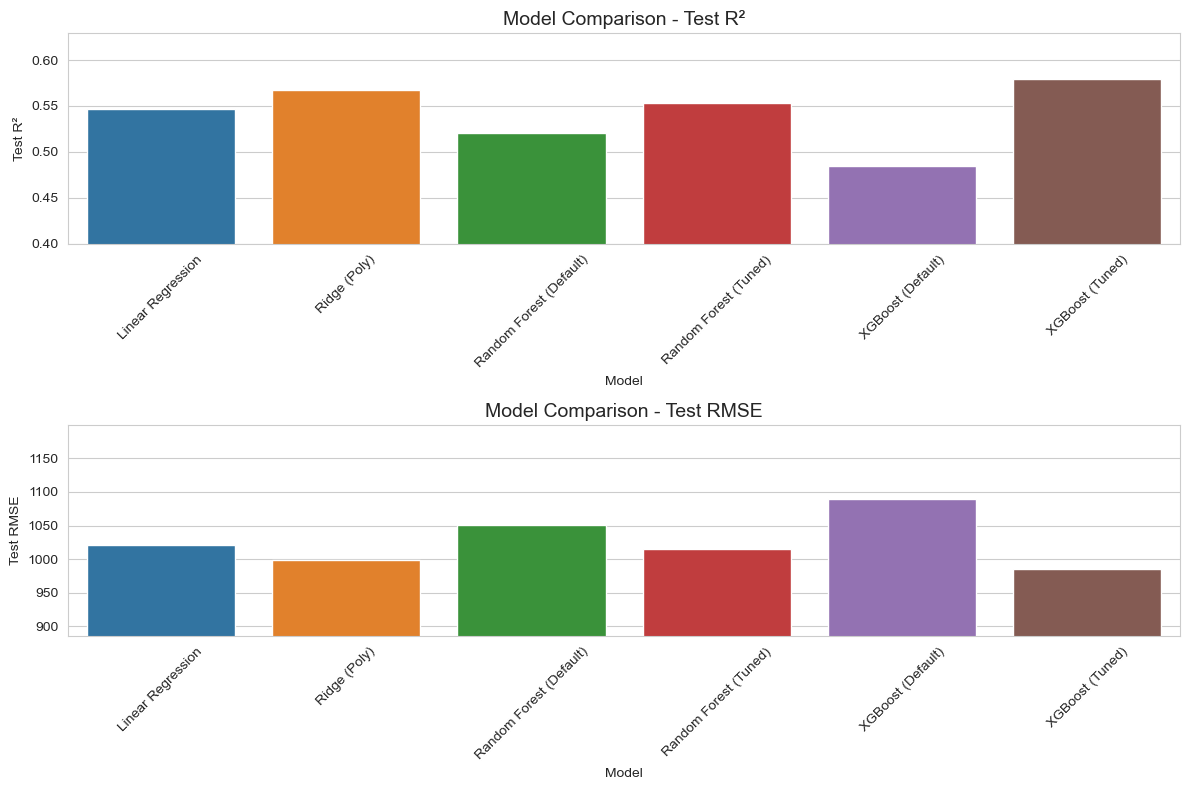


Best model: XGBoost (Tuned)
Test R²: 0.5792
Test RMSE: 984.7107


In [82]:
# =============== XGBOOST TUNING ===============
import xgboost as xgb
# Step 1: Initial XGBoost with default parameters as baseline
print("\n\nTraining baseline XGBoost model...")
xgb_default = xgb.XGBRegressor(random_state=42)
xgb_default.fit(X_train, y_train)

# Evaluate baseline model
xgb_default_train_pred = xgb_default.predict(X_train)
xgb_default_test_pred = xgb_default.predict(X_test)

xgb_default_train_r2 = r2_score(y_train, xgb_default_train_pred)
xgb_default_test_r2 = r2_score(y_test, xgb_default_test_pred)
xgb_default_test_rmse = np.sqrt(mean_squared_error(y_test, xgb_default_test_pred))

print(f"Baseline XGBoost - Train R²: {xgb_default_train_r2:.4f}")
print(f"Baseline XGBoost - Test R²: {xgb_default_test_r2:.4f}")
print(f"Baseline XGBoost - Test RMSE: {xgb_default_test_rmse:.4f}")

# Step 2: Use RandomizedSearchCV for initial parameter exploration
print("\nPerforming RandomizedSearchCV for XGBoost...")
xgb_param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2, 3]
}

xgb_random = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(random_state=42),
    param_distributions=xgb_param_dist,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

start = time.time()
xgb_random.fit(X_train, y_train)
print(f"RandomizedSearchCV completed in {time.time() - start:.2f} seconds")

print("\nBest parameters from RandomizedSearchCV:")
print(xgb_random.best_params_)
print(f"Best RMSE: {-xgb_random.best_score_:.4f}")

# Step 3: Fine-tune with GridSearchCV around the best parameters
print("\nFine-tuning XGBoost with GridSearchCV...")
# Create more focused parameter grid based on RandomizedSearchCV results
best_learning_rate = xgb_random.best_params_['learning_rate']
best_n_estimators = xgb_random.best_params_['n_estimators']
best_max_depth = xgb_random.best_params_['max_depth']
best_min_child_weight = xgb_random.best_params_['min_child_weight']
best_gamma = xgb_random.best_params_['gamma']
best_subsample = xgb_random.best_params_['subsample']
best_colsample_bytree = xgb_random.best_params_['colsample_bytree']
best_reg_alpha = xgb_random.best_params_['reg_alpha']
best_reg_lambda = xgb_random.best_params_['reg_lambda']

# Fine-tune learning rate and n_estimators first
xgb_param_grid1 = {
    'learning_rate': [max(0.01, best_learning_rate - 0.02), best_learning_rate, min(0.5, best_learning_rate + 0.02)],
    'n_estimators': [max(50, best_n_estimators - 50), best_n_estimators, best_n_estimators + 50]
}

xgb_grid1 = GridSearchCV(
    estimator=xgb.XGBRegressor(
        max_depth=best_max_depth,
        min_child_weight=best_min_child_weight,
        gamma=best_gamma,
        subsample=best_subsample,
        colsample_bytree=best_colsample_bytree,
        reg_alpha=best_reg_alpha,
        reg_lambda=best_reg_lambda,
        random_state=42
    ),
    param_grid=xgb_param_grid1,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

start = time.time()
xgb_grid1.fit(X_train, y_train)
print(f"GridSearchCV (learning rate & n_estimators) completed in {time.time() - start:.2f} seconds")

print("\nBest parameters from first GridSearchCV:")
print(xgb_grid1.best_params_)
print(f"Best RMSE: {-xgb_grid1.best_score_:.4f}")

# Update best values
best_learning_rate = xgb_grid1.best_params_['learning_rate']
best_n_estimators = xgb_grid1.best_params_['n_estimators']

# Fine-tune tree-specific parameters
xgb_param_grid2 = {
    'max_depth': [max(1, best_max_depth - 1), best_max_depth, best_max_depth + 1],
    'min_child_weight': [max(1, best_min_child_weight - 1), best_min_child_weight, best_min_child_weight + 1],
    'gamma': [max(0, best_gamma - 0.1), best_gamma, best_gamma + 0.1]
}

xgb_grid2 = GridSearchCV(
    estimator=xgb.XGBRegressor(
        learning_rate=best_learning_rate,
        n_estimators=best_n_estimators,
        subsample=best_subsample,
        colsample_bytree=best_colsample_bytree,
        reg_alpha=best_reg_alpha,
        reg_lambda=best_reg_lambda,
        random_state=42
    ),
    param_grid=xgb_param_grid2,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

start = time.time()
xgb_grid2.fit(X_train, y_train)
print(f"GridSearchCV (tree parameters) completed in {time.time() - start:.2f} seconds")

print("\nBest parameters from second GridSearchCV:")
print(xgb_grid2.best_params_)
print(f"Best RMSE: {-xgb_grid2.best_score_:.4f}")

# Update best values
best_max_depth = xgb_grid2.best_params_['max_depth']
best_min_child_weight = xgb_grid2.best_params_['min_child_weight']
best_gamma = xgb_grid2.best_params_['gamma']

# Fine-tune regularization parameters
xgb_param_grid3 = {
    'reg_alpha': [0, 0.001, 0.01, 0.1, 0.5, 1],
    'reg_lambda': [0.01, 0.1, 1, 2, 5, 10]
}

xgb_grid3 = GridSearchCV(
    estimator=xgb.XGBRegressor(
        learning_rate=best_learning_rate,
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        min_child_weight=best_min_child_weight,
        gamma=best_gamma,
        subsample=best_subsample,
        colsample_bytree=best_colsample_bytree,
        random_state=42
    ),
    param_grid=xgb_param_grid3,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

start = time.time()
xgb_grid3.fit(X_train, y_train)
print(f"GridSearchCV (regularization) completed in {time.time() - start:.2f} seconds")

print("\nBest parameters from third GridSearchCV:")
print(xgb_grid3.best_params_)
print(f"Best RMSE: {-xgb_grid3.best_score_:.4f}")

# Update best values
best_reg_alpha = xgb_grid3.best_params_['reg_alpha']
best_reg_lambda = xgb_grid3.best_params_['reg_lambda']

# Step 4: Train final XGBoost model with all best parameters
xgb_best = xgb.XGBRegressor(
    learning_rate=best_learning_rate,
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    gamma=best_gamma,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    reg_alpha=best_reg_alpha,
    reg_lambda=best_reg_lambda,
    random_state=42
)

xgb_best.fit(X_train, y_train)

# Evaluate final XGBoost model
xgb_best_train_pred = xgb_best.predict(X_train)
xgb_best_test_pred = xgb_best.predict(X_test)

xgb_best_train_r2 = r2_score(y_train, xgb_best_train_pred)
xgb_best_test_r2 = r2_score(y_test, xgb_best_test_pred)
xgb_best_test_rmse = np.sqrt(mean_squared_error(y_test, xgb_best_test_pred))

print("\nOptimized XGBoost Results:")
print(f"Train R²: {xgb_best_train_r2:.4f}")
print(f"Test R²: {xgb_best_test_r2:.4f}")
print(f"Test RMSE: {xgb_best_test_rmse:.4f}")

# Feature importance for XGBoost
xgb_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_best.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 most important features (XGBoost):")
print(xgb_feature_importance.head(10))

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=xgb_feature_importance.head(15))
plt.title('XGBoost - Feature Importances (Top 15)')
plt.tight_layout()
plt.savefig('xgb_feature_importance.png', dpi=300)
plt.show()

# =============== MODEL COMPARISON ===============

# Create a comparison table
models = ['Linear Regression', 'Ridge (Poly)', 'Random Forest (Default)', 
          'Random Forest (Tuned)', 'XGBoost (Default)', 'XGBoost (Tuned)']

# Assuming you have the metrics from your Linear Regression and Ridge models
# If not, use placeholder values
lin_reg_train_r2 = 0.552  # Update with your actual value
lin_reg_test_r2 = 0.547   # Update with your actual value
lin_reg_test_rmse = 1021.5  # Update with your actual value

ridge_poly_train_r2 = 0.600  # Update with your actual value
ridge_poly_test_r2 = 0.567   # Update with your actual value
ridge_poly_test_rmse = 998.9  # Update with your actual value

train_r2_scores = [lin_reg_train_r2, ridge_poly_train_r2, 
                  rf_default_train_r2, rf_best_train_r2, 
                  xgb_default_train_r2, xgb_best_train_r2]

test_r2_scores = [lin_reg_test_r2, ridge_poly_test_r2, 
                 rf_default_test_r2, rf_best_test_r2, 
                 xgb_default_test_r2, xgb_best_test_r2]

test_rmse_scores = [lin_reg_test_rmse, ridge_poly_test_rmse, 
                   rf_default_test_rmse, rf_best_test_rmse, 
                   xgb_default_test_rmse, xgb_best_test_rmse]

model_comparison = pd.DataFrame({
    'Model': models,
    'Train R²': train_r2_scores,
    'Test R²': test_r2_scores,
    'Test RMSE': test_rmse_scores
})

print("\n=============== MODEL COMPARISON ===============")
print(model_comparison)

# Plot model comparison
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
sns.barplot(x='Model', y='Test R²', data=model_comparison)
plt.title('Model Comparison - Test R²', fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0.4, max(test_r2_scores) + 0.05)

plt.subplot(2, 1, 2)
sns.barplot(x='Model', y='Test RMSE', data=model_comparison)
plt.title('Model Comparison - Test RMSE', fontsize=14)
plt.xticks(rotation=45)
plt.ylim(min(test_rmse_scores) * 0.9, max(test_rmse_scores) * 1.1)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300)
plt.show()

# Select the best model based on Test R²
best_model_idx = model_comparison['Test R²'].argmax()
best_model_name = model_comparison.iloc[best_model_idx]['Model']
best_r2 = model_comparison.iloc[best_model_idx]['Test R²']
best_rmse = model_comparison.iloc[best_model_idx]['Test RMSE']

print(f"\nBest model: {best_model_name}")
print(f"Test R²: {best_r2:.4f}")
print(f"Test RMSE: {best_rmse:.4f}")

In [83]:
# Make predictions on test data
test_predictions = xgb_best.predict(test)
submission = pd.DataFrame({
    'Item_Identifier': test_ids,
    'Outlet_Identifier': test_outlets,
    'Item_Outlet_Sales': test_predictions
})
# Export submission to CSV
submission.to_csv('bigmart_sales_prediction12.csv', index=False)
print("\nSubmission file created successfully!")
submission


Submission file created successfully!


,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1669.714111
1,FDW14,OUT017,1425.120850
2,NCN55,OUT010,731.105530
3,FDQ58,OUT017,2509.042480
4,FDY38,OUT027,4445.518555
...,...,...,...
5676,FDB58,OUT046,2174.991455
5677,FDD47,OUT018,2669.405029
5678,NCO17,OUT045,1854.465576
5679,FDJ26,OUT017,3493.922607


In [84]:
xgb_feature_importance

,Feature,Importance
28,Outlet_Identifier_OUT019,0.327558
2,Item_MRP,0.187444
5,Outlet_Type,0.182036
29,Outlet_Identifier_OUT027,0.100685
7,Outlet_Years,0.054426
3,Outlet_Size,0.012205
33,Outlet_Identifier_OUT049,0.011181
27,Outlet_Identifier_OUT018,0.010225
11,Item_Type_Dairy,0.010179
21,Item_Type_Soft Drinks,0.009744


In [85]:
rf_feature_importance

,Feature,Importance
2,Item_MRP,0.474385
5,Outlet_Type,0.160793
1,Item_Visibility,0.059879
6,Weight_Interpolate,0.056178
7,Outlet_Years,0.048986
28,Outlet_Identifier_OUT019,0.042806
29,Outlet_Identifier_OUT027,0.039051
3,Outlet_Size,0.023488
4,Outlet_Location_Type,0.022989
32,Outlet_Identifier_OUT046,0.007817


Training baseline Random Forest model...
Baseline Random Forest - Train R²: 0.0309
Baseline Random Forest - Test R²: 0.0095
Baseline Random Forest - Test RMSE: 1510.8132

Performing RandomizedSearchCV for Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
RandomizedSearchCV completed in 170.24 seconds

Best parameters from RandomizedSearchCV:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10}
Best RMSE: 984.8596

Fine-tuning Random Forest with GridSearchCV...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
GridSearchCV completed in 271.12 seconds

Best parameters from GridSearchCV:
{'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 250}
Best RMSE: 1002.6417

Optimized Random Forest Results:
Train R²: 0.6861
Test R²: 0.5531
Test RMSE: 1014.8348

Top 10 most important features (Random Forest):
                     Feature  Importance
2  

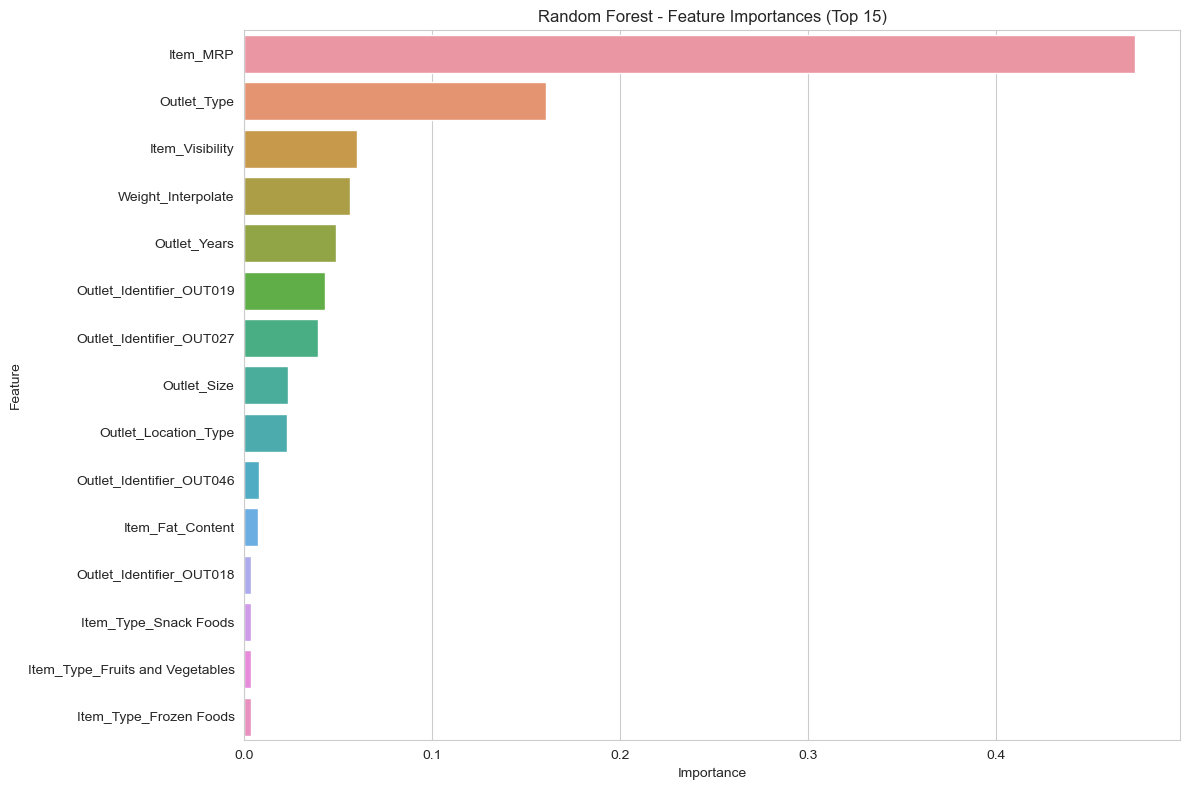

In [87]:
# List of columns to remove
columns_to_remove = [
    'Item_MRP', 
    'Outlet_Type', 
    'Item_Visibility', 
    'Weight_Interpolate', 
    'Outlet_Years', 
    'Outlet_Identifier_OUT019', 
    'Outlet_Identifier_OUT027', 
    'Outlet_Size', 
    'Outlet_Location_Type', 
    'Outlet_Identifier_OUT046', 
    'Item_Fat_Content'
]

X_train_filtered = X_train.drop(columns=columns_to_remove)
X_test_filtered = X_test.drop(columns=columns_to_remove)
test_filtered = test.drop(columns=columns_to_remove)

# Step 1: Initial Random Forest with default parameters as baseline
print("Training baseline Random Forest model...")
rf_default = RandomForestRegressor(random_state=42)
rf_default.fit(X_train_filtered, y_train)

# Evaluate baseline model
rf_default_train_pred = rf_default.predict(X_train_filtered)
rf_default_test_pred = rf_default.predict(X_test_filtered)

rf_default_train_r2 = r2_score(y_train, rf_default_train_pred)
rf_default_test_r2 = r2_score(y_test, rf_default_test_pred)
rf_default_test_rmse = np.sqrt(mean_squared_error(y_test, rf_default_test_pred))

print(f"Baseline Random Forest - Train R²: {rf_default_train_r2:.4f}")
print(f"Baseline Random Forest - Test R²: {rf_default_test_r2:.4f}")
print(f"Baseline Random Forest - Test RMSE: {rf_default_test_rmse:.4f}")

# Step 2: Use RandomizedSearchCV for initial parameter exploration
print("\nPerforming RandomizedSearchCV for Random Forest...")
rf_param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=rf_param_dist,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

start = time.time()
rf_random.fit(X_train, y_train)
print(f"RandomizedSearchCV completed in {time.time() - start:.2f} seconds")

print("\nBest parameters from RandomizedSearchCV:")
print(rf_random.best_params_)
print(f"Best RMSE: {-rf_random.best_score_:.4f}")

# Step 3: Fine-tune with GridSearchCV around the best parameters
print("\nFine-tuning Random Forest with GridSearchCV...")
# Create more focused parameter grid based on RandomizedSearchCV results
best_n_estimators = rf_random.best_params_['n_estimators']
best_max_depth = rf_random.best_params_['max_depth']
best_min_samples_split = rf_random.best_params_['min_samples_split']
best_min_samples_leaf = rf_random.best_params_['min_samples_leaf']
best_max_features = rf_random.best_params_['max_features']

rf_param_grid = {
    'n_estimators': [best_n_estimators - 50, best_n_estimators, best_n_estimators + 50],
    'max_depth': [best_max_depth - 5 if best_max_depth is not None and best_max_depth > 5 else None, 
                  best_max_depth, 
                  best_max_depth + 5 if best_max_depth is not None else None],
    'min_samples_split': [max(2, best_min_samples_split - 2), best_min_samples_split, best_min_samples_split + 2],
    'min_samples_leaf': [max(1, best_min_samples_leaf - 1), best_min_samples_leaf, best_min_samples_leaf + 1],
    'max_features': [best_max_features]
}

# Remove None values from the grid to avoid errors
for param, values in rf_param_grid.items():
    rf_param_grid[param] = [v for v in values if v is not None]
    if not rf_param_grid[param]:  # If list became empty, add a default
        if param == 'max_depth':
            rf_param_grid[param] = [None]
        elif param == 'max_features':
            rf_param_grid[param] = ['sqrt']

rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=rf_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

start = time.time()
rf_grid.fit(X_train, y_train)
print(f"GridSearchCV completed in {time.time() - start:.2f} seconds")

print("\nBest parameters from GridSearchCV:")
print(rf_grid.best_params_)
print(f"Best RMSE: {-rf_grid.best_score_:.4f}")

# Step 4: Evaluate final Random Forest model
rf_best = rf_grid.best_estimator_
rf_best_train_pred = rf_best.predict(X_train)
rf_best_test_pred = rf_best.predict(X_test)

rf_best_train_r2 = r2_score(y_train, rf_best_train_pred)
rf_best_test_r2 = r2_score(y_test, rf_best_test_pred)
rf_best_test_rmse = np.sqrt(mean_squared_error(y_test, rf_best_test_pred))

print("\nOptimized Random Forest Results:")
print(f"Train R²: {rf_best_train_r2:.4f}")
print(f"Test R²: {rf_best_test_r2:.4f}")
print(f"Test RMSE: {rf_best_test_rmse:.4f}")

# Feature importance for Random Forest
rf_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_best.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 most important features (Random Forest):")
print(rf_feature_importance.head(10))

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=rf_feature_importance.head(15))
plt.title('Random Forest - Feature Importances (Top 15)')
plt.tight_layout()
plt.savefig('rf_feature_importance.png', dpi=300)
plt.show()

In [89]:
# Make predictions on test data
test_predictions = rf_best.predict(test)
submission = pd.DataFrame({
    'Item_Identifier': test_ids,
    'Outlet_Identifier': test_outlets,
    'Item_Outlet_Sales': test_predictions
})
# Export submission to CSV
submission.to_csv('bigmart_sales_prediction13.csv', index=False)
print("\nSubmission file created successfully!")
submission


Submission file created successfully!


,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1878.754754
1,FDW14,OUT017,1470.306240
2,NCN55,OUT010,691.682078
3,FDQ58,OUT017,2482.595925
4,FDY38,OUT027,3818.775003
...,...,...,...
5676,FDB58,OUT046,2130.111533
5677,FDD47,OUT018,2758.366564
5678,NCO17,OUT045,1730.202634
5679,FDJ26,OUT017,3585.077503
